# Imports

In [2]:
import os
import sys
import re
import numpy as np
import pandas as pd
import json

In [3]:
from datetime import datetime, timedelta
import hashlib

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
sys.path.append('../')
import spell.spell as s
import edit

sys.path.append('../src/')
sys.path.append('../spell/')

In [6]:
import Reader
import ParamsExtractor2
import DataPreprocessor
import ReduceDim
import ClusterData
import OneClass
import DetectAnomaly

2024-10-15 09:15:51.236010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-15 09:15:51.299127: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 09:15:52.113231: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
import EncodeCommand
import DeepLearningAnomalyDetection2
import TimeDependentDeepLearningAnomalyDetection

In [8]:
from normal_utilities import *
from silent_utilities import *
from silent_utilities_2 import *
from preprocess_utilities import *

# Creation of datasets

## Normal execution

In [ ]:
fp = '../../../../../temp_logs/20240418/login01.laurel.log'
df = read(fp)
df_expanded = df['message'].apply(parse_audit_log).apply(pd.Series)
df = pd.concat([df, df_expanded], axis=1)
df.head()
df = preprocess_laurel(df)
save(df, fp + '.csv')

In [ ]:
normal_dataset_fp = fp + '.csv'
new_path = '../cleaned_data/normal.csv'
save(df, new_path)

## LinPeas noisy execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/laurel_anomalous_new/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,8)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

## LinPeas silent execution on laurel

In [ ]:
# First type of log file:
# laurel_anomalous_new
fp = '../data/silent/audit.log'
fps = [fp]
fps += [fp + f'.{str(i)}' for i in range(1,11)]
print(fps)

In [ ]:
for fp in fps:
    df = read(fp)
    df = preprocess_laurel(df)
    save(df, fp + '.csv')

In [ ]:
import os

def concatenate_files(input_files, output_file):
    with open(output_file, 'w') as outfile:
        for filename in input_files:
            with open(filename, 'r') as infile:
                # Read each input file and write its content to the output file
                outfile.write(infile.read())
                outfile.write("\n")  # Optional: Adds a newline between files

# List of 10 input files (full paths or filenames)
input_files = ['../data/silent/audit.log', '../data/silent/audit.log.1', '../data/silent/audit.log.2', '../data/silent/audit.log.3', '../data/silent/audit.log.4', '../data/silent/audit.log.5', '../data/silent/audit.log.6', '../data/silent/audit.log.7', '../data/silent/audit.log.8', '../data/silent/audit.log.9', '../data/silent/audit.log.10']
input_files = input_files[::-1]
# Output file where the concatenated content will be written
output_file = 'silent.log'

# Call the function to concatenate the files
concatenate_files(input_files, output_file)

print(f"All files have been concatenated into {output_file}")

In [ ]:
# merge the csv files
fp = '../data/silent.log'
df = read(fp)
df = preprocess_laurel(df)
save(df, fp + '.csv')

## Normal Execution on secure

In [19]:
from normal_utilities import *

In [20]:
fp = '../../../../../temp_logs/20240418/login01.secure.log'
save_fp = '../cleaned_data/secure_normal.csv'
df = read(fp)

p = ParamsExtractor2.ParamsExtractor(df)
df = p.convert_params(df)
new_df = p.get_params()

df = pd.concat([df, new_df], axis=1)
df.head()
save(df, save_fp)

In [21]:
df.shape

(56516, 17)

In [22]:
df.head()

host    ident    pid                                            message  \
0  login01  systemd  37690  pam_unix(systemd-user:session): session opened...   
1  login01     sshd  37759  Accepted publickey for root from 10.44.0.12 po...   
2  login01     sshd  37759  pam_unix(sshd:session): session opened for use...   
3  login01     sshd  37765  Received disconnect from 10.44.0.12 port 44266...   
4  login01     sshd  37765  Disconnected from user root 10.44.0.12 port 44266   

  severity  facility                       time  severity_numbers  \
0     info  authpriv  2024-04-18 00:00:01 +0200                 6   
1     info  authpriv  2024-04-18 00:00:02 +0200                 6   
2     info  authpriv  2024-04-18 00:00:02 +0200                 6   
3     info  authpriv  2024-04-18 00:00:02 +0200                 6   
4     info  authpriv  2024-04-18 00:00:02 +0200                 6   

   facility_numbers  severity_scores  timedelta user          ip   port  \
0                10              1.0        0.0   -1          -1     -1   
1                10              1.0        1.0   -1  10.44.0.12  44266   
2                10              1.0        0.0   -1          -1     -1   
3                10              1.0        0.0   -1  10.44.0.12  44266   
4                10              1.0        0.0   -1  10.44.0.12  44266   

  session  log key  log key spell  
0  opened        0             -1  
1      -1        1             52  
2  opened        0             -1  
3      -1        2             -1  
4      -1        3             55

# Preprocessing

## Log Keys Clustering

### Tokenization and word embedding

Log keys obtained by simple tokenization approach

In [8]:
# Specify the path to your JSON file
file_path = 'log_key.json'

# Open and load the JSON file
with open(file_path, 'r') as file:
    data = json.load(file)

# Print the data to see the content
for key, value in data.items():
    if value == 0:
        print(f"Key with value 0: {key}")

Key with value 0: pam_unix(*): session * for user * by (*)


In [10]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel

# Initialize the TinyBERT tokenizer and model from HuggingFace Transformers
tokenizer = BertTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = BertModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

class DimensionalityReducer(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DimensionalityReducer, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define the reducer with TinyBERT embedding size and desired output size
reducer = DimensionalityReducer(input_dim=312, output_dim=10)

def get_tinybert_embedding(text):
    """
    Get TinyBERT embeddings from text input.
    """
    # Tokenize the input text and convert to tensor
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    
    # Get the TinyBERT embeddings (last_hidden_state)
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Use the [CLS] token's embedding (index 0)
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # Shape: (1, 312)
    return cls_embedding

def get_reduced_tinybert_embedding(text):
    """
    Get TinyBERT embeddings for a text and reduce its dimensionality.
    """
    # Get the TinyBERT embedding (shape: (1, 312))
    embedding = get_tinybert_embedding(text)
    
    # Reduce the dimensionality using the reducer (from 312 to 10 dimensions)
    reduced_embedding = reducer(embedding).detach().numpy()  # Detach to get a numpy array
    
    return reduced_embedding

# Example usage
if __name__ == '__main__':
    text = "This is a test sentence."
    
    # Get the reduced embedding
    reduced_embedding = get_reduced_tinybert_embedding(text)
    
    print("Reduced Embedding Shape:", reduced_embedding.shape)  # Expected output: (1, 10)
    print(reduced_embedding)  # Display the reduced embedding


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Reduced Embedding Shape: (1, 10)
[[ 0.3021575   0.20983419 -0.05008744 -0.04918498 -0.03579481  0.30249134
  -0.00389133 -0.00154948  0.2998334   0.32127586]]


In [11]:
keys_list = []
for k, v in data.items():
    keys_list.append(k)

print(keys_list[0])

pam_unix(*): session * for user * by (*)


In [12]:
def save_embeddings_to_json(sentences, file_path):
    embeddings_dict = {}
    
    for sentence in sentences:
        reduced_embedding = get_reduced_tinybert_embedding(sentence)
        embeddings_dict[sentence] = reduced_embedding.tolist()  # Convert numpy array to list

    # Save to JSON file
    with open(file_path, 'w') as json_file:
        json.dump(embeddings_dict, json_file, indent=4)

output_file_path = 'embeddings.json'

save_embeddings_to_json(keys_list, output_file_path)
print(f"Embeddings saved to {output_file_path}.")

Embeddings saved to embeddings.json.


### Distance approaches

In [13]:
secure_fp = '../cleaned_data/secure_normal.csv'
df = pd.read_csv(secure_fp)

In [14]:
df.head()

host    ident    pid                                            message  \
0  login01  systemd  37690  pam_unix(systemd-user:session): session opened...   
1  login01     sshd  37759  Accepted publickey for root from 10.44.0.12 po...   
2  login01     sshd  37759  pam_unix(sshd:session): session opened for use...   
3  login01     sshd  37765  Received disconnect from 10.44.0.12 port 44266...   
4  login01     sshd  37765  Disconnected from user root 10.44.0.12 port 44266   

  severity  facility                       time  severity_numbers  \
0     info  authpriv  2024-04-18 00:00:01 +0200                 6   
1     info  authpriv  2024-04-18 00:00:02 +0200                 6   
2     info  authpriv  2024-04-18 00:00:02 +0200                 6   
3     info  authpriv  2024-04-18 00:00:02 +0200                 6   
4     info  authpriv  2024-04-18 00:00:02 +0200                 6   

   facility_numbers  severity_scores  timedelta  user          ip   port  \
0                10              1.0        0.0    -1          -1     -1   
1                10              1.0        1.0    -1  10.44.0.12  44266   
2                10              1.0        0.0    -1          -1     -1   
3                10              1.0        0.0    -1  10.44.0.12  44266   
4                10              1.0        0.0    -1  10.44.0.12  44266   

  session  log key  log key spell  
0  opened        0             -1  
1      -1        1             52  
2  opened        0             -1  
3      -1        2             -1  
4      -1        3             55

In [14]:
def get_message_list(df):
    # Initialize an empty list to store messages
    message_list = []
    
    # Iterate through each row in the DataFrame and append the 'message' column value to the list
    for message in df['message']:
        message_list.append(message)
    
    return message_list


In [16]:
list_of_log_entries = get_message_list(df)
print(list_of_log_entries[0])

pam_unix(systemd-user:session): session opened for user a07cmc01 by (uid=0)


In [15]:
def save_dump(edm, filename):
    """
    Save the dump of an EditDistanceMap object to a text file.
    
    Args:
    edm (EditDistanceMap): The EditDistanceMap object to dump.
    filename (str): The name of the file to save the dump to.
    """
    with open(filename, 'w') as f:
        for i, obj in enumerate(edm._objs):
            json_str = obj.tojson()
            f.write(f"{i} {json_str}\n")

# Example usage:
# edm = EditDistanceMap(r'[\s]+')
# ... (populate edm with data)
# save_dump(edm, 'edm_dump.txt')

In [16]:
def save_dump_lcsmap(slm, filename):
    """
    Save the dump of a lcsmap object to a text file.
    
    Args:
    slm (lcsmap): The lcsmap object to dump.
    filename (str): The name of the file to save the dump to.
    """
    with open(filename, 'w') as f:
        for i in range(slm.size()):
            obj = slm.objat(i)
            data = {
                'lcsseq': obj._lcsseq,
                'lineids': obj._lineids
            }
            json_str = json.dumps(data)
            f.write(f"{i} {json_str}\n")

# Example usage:
# slm = s.lcsmap('[\\s]+')
# ... (populate slm with data)
# save_dump_lcsmap(slm, 'spell_dump.txt')

#### Spell

In [19]:
slm = s.lcsmap('[\\s]+')
# Now we try spell algorithm
for i in list_of_log_entries:
    sub = i.strip('\n')
    obj = slm.insert(sub)
    #print(obj.get_id(), obj.param(sub))

s.save('slm.pickle', slm)

slm.dump()
save_dump_lcsmap(slm, 'spell_dump.txt')

0 {"lcsseq": "* session * for user * ", "lineids": [1, 3, 6, 12, 18, 19, 22, 26, 32, 38, 44, 48, 51, 55, 60, 65, 68, 69, 72, 73, 74, 75, 76, 77, 78, 79, 82, 92, 96, 99, 103, 107, 114, 122, 127, 130, 134, 138, 146, 150, 154, 161, 165, 169, 172, 181, 186, 192, 202, 206, 226, 233, 237, 242, 245, 259, 278, 290, 300, 308, 318, 325, 329, 337, 348, 357, 366, 371, 382, 384, 389, 402, 407, 416, 428, 446, 455, 465, 469, 477, 481, 491, 494, 498, 510, 520, 527, 531, 537, 540, 549, 550, 554, 557, 563, 569, 570, 576, 580, 588, 595, 600, 601, 603, 604, 608, 609, 610, 611, 612, 613, 614, 617, 621, 629, 650, 660, 671, 683, 690, 708, 712, 726, 730, 733, 745, 750, 754, 758, 762, 765, 774, 788, 791, 799, 803, 806, 808, 816, 821, 830, 833, 842, 856, 861, 869, 875, 878, 888, 894, 897, 914, 921, 925, 933, 938, 941, 954, 972, 973, 979, 985, 1001, 1008, 1012, 1020, 1026, 1031, 1039, 1044, 1060, 1064, 1074, 1077, 1080, 1083, 1089, 1092, 1101, 1102, 1106, 1109, 1115, 1121, 1127, 1131, 1136, 1140, 1144, 1145, 114

#### Edit Distance

In [20]:
import re
from edit.edit import EditDistanceMap, save, load

# Create an instance of EditDistanceMap
edm = EditDistanceMap(r'[\s]+')

# Process log entries
for entry in list_of_log_entries:
    sub = entry.strip()
    obj = edm.insert(sub)
    #print(f"Inserted: {sub}")
    #print(f"Object ID: {obj.get_id()}")
    #print(f"Edit Distance: {obj.get_distance(sub)}")
    #print("---")

# Save the EditDistanceMap object
save('edm.pickle', edm)

# Dump the contents of the EditDistanceMap
print("Dumping EditDistanceMap contents:")
edm.dump()
save_dump(edm, 'edit_dist_dump.txt')

# Load the saved EditDistanceMap
loaded_edm = load('edm.pickle')

if loaded_edm:
    print("\nLoaded EditDistanceMap contents:")
    loaded_edm.dump()
else:
    print("\nFailed to load EditDistanceMap")

Dumping EditDistanceMap contents:
0 {"sequence": "pam_unix(systemd-user:session): session opened for user a07cmc01 by (uid=0)", "lineids": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

#### Modified Edit Distance

In [21]:
import re
from edit.modified_edit import EditDistanceMap, save, load

# Create an instance of EditDistanceMap
edm = EditDistanceMap(r'[\s]+')

# Process log entries
for entry in list_of_log_entries:
    sub = entry.strip()
    obj = edm.insert(sub)
    #print(f"Inserted: {sub}")
    #print(f"Object ID: {obj.get_id()}")
    #print(f"Edit Distance: {obj.get_distance(sub)}")
    #print("---")

# Save the EditDistanceMap object
save('edm.pickle', edm)

# Dump the contents of the EditDistanceMap
print("Dumping EditDistanceMap contents:")
edm.dump()
save_dump(edm, 'modified_edit_dist_dump.txt')

# Load the saved EditDistanceMap
loaded_edm = load('edm.pickle')

if loaded_edm:
    print("\nLoaded EditDistanceMap contents:")
    loaded_edm.dump()
else:
    print("\nFailed to load EditDistanceMap")

Dumping EditDistanceMap contents:
0 {"sequence": "pam_unix(systemd-user:session): session opened for user a07cmc01 by (uid=0)", "lineids": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197, 198, 199, 200, 201, 202, 203, 20

### Comparison (secure dataset)

In [23]:
import json
from collections import defaultdict

import json
from collections import defaultdict

def load_dump(filename):
    clusters = defaultdict(list)
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f, 1):
            parts = line.strip().split(' ', 1)
            if len(parts) == 2:
                index, data = parts
                try:
                    obj = json.loads(data)
                    print(f"Line {line_num}: Object structure: {obj.keys()}")
                    
                    # Try to find sequence and lineids in different possible structures
                    sequence = None
                    lineids = None
                    
                    if 'sequence' in obj and 'lineids' in obj:
                        sequence = obj['sequence']
                        lineids = obj['lineids']
                    elif 'lcsseq' in obj and 'lineids' in obj:
                        sequence = ' '.join(obj['lcsseq'])
                        lineids = obj['lineids']
                    elif '_lcsseq' in obj and '_lineids' in obj:
                        sequence = ' '.join(obj['_lcsseq'])
                        lineids = obj['_lineids']
                    elif isinstance(obj, list) and len(obj) >= 2:
                        # If the object is a list, assume the first element is the sequence
                        # and the second is the list of lineids
                        sequence = ' '.join(obj[0]) if isinstance(obj[0], list) else str(obj[0])
                        lineids = obj[1] if isinstance(obj[1], list) else [obj[1]]
                    else:
                        # If we can't identify the structure, use the whole object as the sequence
                        sequence = str(obj)
                        lineids = [line_num]
                    
                    if sequence and lineids:
                        clusters[sequence].extend(lineids)
                    else:
                        print(f"Warning: Couldn't parse line {line_num}: {line}")
                except json.JSONDecodeError:
                    print(f"Warning: Couldn't parse JSON in line {line_num}: {line}")
    return clusters

def analyze_clustering(clusters):
    num_clusters = len(clusters)
    total_items = sum(len(lineids) for lineids in clusters.values())
    avg_cluster_size = total_items / num_clusters if num_clusters > 0 else 0
    largest_cluster = max(len(lineids) for lineids in clusters.values())
    singleton_clusters = sum(1 for lineids in clusters.values() if len(lineids) == 1)
    
    return {
        'num_clusters': num_clusters,
        'total_items': total_items,
        'avg_cluster_size': avg_cluster_size,
        'largest_cluster': largest_cluster,
        'singleton_clusters': singleton_clusters
    }

def compare_clusterings(spell_file, edit_dist_file, modified_edit_dist_file):
    spell_clusters = load_dump(spell_file)
    edit_dist_clusters = load_dump(edit_dist_file)
    modified_edit_dist_clusters = load_dump(modified_edit_dist_file)
    
    spell_analysis = analyze_clustering(spell_clusters)
    edit_dist_analysis = analyze_clustering(edit_dist_clusters)
    modified_edit_dist_analysis = analyze_clustering(modified_edit_dist_clusters)
    
    print("Spell Clustering Analysis:")
    print(json.dumps(spell_analysis, indent=2))
    print("\nEdit Distance Clustering Analysis:")
    print(json.dumps(edit_dist_analysis, indent=2))
    print("\nModified Edit Distance Clustering Analysis:")
    print(json.dumps(modified_edit_dist_analysis, indent=2))
    
    # Compare specific clusters
    print("\nComparing specific clusters:")
    all_sequences = set(spell_clusters.keys()) | set(edit_dist_clusters.keys()) | set(modified_edit_dist_clusters.keys())
    for seq in all_sequences:
        print(f"\nSequence: {seq}")
        print(f"Spell: {len(spell_clusters.get(seq, []))} items")
        print(f"Edit Distance: {len(edit_dist_clusters.get(seq, []))} items")
        print(f"Modified Edit Distance: {len(modified_edit_dist_clusters.get(seq, []))} items")

# Usage
compare_clusterings('spell_dump.txt', 'edit_dist_dump.txt', 'modified_edit_dist_dump.txt')

Line 1: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 2: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 3: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 4: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 5: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 6: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 7: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 8: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 9: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 10: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 11: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 12: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 13: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 14: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 15: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 16: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 17: Object structure: dict_keys(['lcsseq', '

### Comparison (full dataset)

In [10]:
log_types = ['cron', 'maillog', 'messages', 'secure', 'user']
#dates = ['20240418', '20240420', '20240429']
#login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/20240418/login01.{logtype}.log' for logtype in log_types]
#file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file_no_limit(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.cron.log', '/../../../temp_logs/20240418/login01.maillog.log', '/../../../temp_logs/20240418/login01.messages.log', '/../../../temp_logs/20240418/login01.secure.log', '/../../../temp_logs/20240418/login01.user.log']


In [11]:
list_of_log_entries = [entry for df in df_list for entry in df['message']]
print(len(list_of_log_entries))

531472


In [17]:
from tqdm import tqdm

slm = s.lcsmap('[\\s]+')
# Now we try spell algorithm
for i in tqdm(list_of_log_entries, desc="Processing log entries"):
    sub = i.strip('\n')
    obj = slm.insert(sub)
    #print(obj.get_id(), obj.param(sub))

s.save('slm_full.pickle', slm)

#slm.dump()
save_dump_lcsmap(slm, 'spell_dump_full.txt')

Processing log entries:   7%|██▊                                     | 36969/531472 [00:09<02:04, 3968.10it/s]


KeyboardInterrupt: 

In [20]:
import re
from edit.edit import EditDistanceMap, save, load
# Create an instance of EditDistanceMap
edm = EditDistanceMap(r'[\s]+')

# Process log entries
for entry in tqdm(list_of_log_entries, desc="Processing log entries"):
    sub = entry.strip()
    obj = edm.insert(sub)
    #print(f"Inserted: {sub}")
    #print(f"Object ID: {obj.get_id()}")
    #print(f"Edit Distance: {obj.get_distance(sub)}")
    #print("---")

# Save the EditDistanceMap object
save('edm_full.pickle', edm)

# Dump the contents of the EditDistanceMap
#print("Dumping EditDistanceMap contents:")
#edm.dump()
save_dump(edm, 'edit_dist_dump_full.txt')

# Load the saved EditDistanceMap
loaded_edm = load('edm.pickle')

if loaded_edm:
    print("\nLoaded EditDistanceMap contents:")
    loaded_edm.dump()
else:
    print("\nFailed to load EditDistanceMap")

Processing log entries: 100%|██████████████████████████████████████| 531472/531472 [00:15<00:00, 35268.76it/s]


Dumping EditDistanceMap contents:
edm.pickle isn't an EditDistanceMap object

Failed to load EditDistanceMap


In [21]:
import re
from edit.modified_edit import EditDistanceMap, save, load

# Create an instance of EditDistanceMap
edm = EditDistanceMap(r'[\s]+')

# Process log entries
for entry in tqdm(list_of_log_entries, desc="Processing log entries"):
    sub = entry.strip()
    obj = edm.insert(sub)
    #print(f"Inserted: {sub}")
    #print(f"Object ID: {obj.get_id()}")
    #print(f"Edit Distance: {obj.get_distance(sub)}")
    #print("---")

# Save the EditDistanceMap object
save('medm_full.pickle', edm)

# Dump the contents of the EditDistanceMap
print("Dumping EditDistanceMap contents:")
#edm.dump()
save_dump(edm, 'modified_edit_dist_dump_full.txt')

# Load the saved EditDistanceMap
loaded_edm = load('edm.pickle')

if loaded_edm:
    print("\nLoaded EditDistanceMap contents:")
    loaded_edm.dump()
else:
    print("\nFailed to load EditDistanceMap")

Processing log entries: 100%|██████████████████████████████████████| 531472/531472 [00:24<00:00, 22007.66it/s]


Dumping EditDistanceMap contents:

Loaded EditDistanceMap contents:
0 {"sequence": "pam_unix(systemd-user:session): session opened for user a07cmc01 by (uid=0)", "lineids": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 195, 196, 197

In [24]:
# Usage
compare_clusterings('spell_dump_full.txt', 'edit_dist_dump_full.txt', 'modified_edit_dist_dump_full.txt')

Line 1: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 2: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 3: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 4: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 5: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 6: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 7: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 8: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 9: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 10: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 11: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 12: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 13: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 14: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 15: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 16: Object structure: dict_keys(['lcsseq', 'lineids'])
Line 17: Object structure: dict_keys(['lcsseq', '

## Data Reading

In [75]:
normal = pd.read_csv('../cleaned_data/normal.csv')
anomalous = pd.read_csv('../cleaned_data/anomalous0.csv')
silent = pd.read_csv('../cleaned_data/silent.log.csv')

In [76]:
encoder = EncodeCommand.EncodeCommand()
normal_ = preprocess(normal,encoder)
anomalous_ = preprocess(anomalous, encoder)
silent_ = preprocess(silent, encoder)

In [77]:
normal_.shape, anomalous_.shape, silent_.shape

((100000, 9), (1000, 9), (31006, 9))

In [78]:
normal_.head()

exit  items      ppid       pid  timedelta  id_anomalies  num_id_anomalies  \
0   0.0    2.0  0.781250  0.230469      0.000           0.0               0.0   
1   0.0    3.0  0.636719  0.417969      1.862           0.0               8.0   
2   0.0    0.0  0.539062  0.539062      0.002           0.0               0.0   
3   0.0    0.0  0.539062  0.539062      0.006           0.0               0.0   
4   0.0    0.0  0.539062  0.539062      0.001           0.0               0.0   

   fp_length  enc_comm  
0        0.0       1.0  
1        0.0       2.0  
2        0.0       3.0  
3        0.0       3.0  
4        0.0       3.0

In [79]:
anomalous_.head()

exit  items      ppid       pid  timedelta  id_anomalies  num_id_anomalies  \
0  -2.0    1.0  0.644531  0.890625        0.0           0.0               0.0   
1  -2.0    1.0  0.644531  0.890625        0.0           0.0               0.0   
2  -2.0    1.0  0.644531  0.890625        0.0           0.0               0.0   
3  -2.0    1.0  0.644531  0.890625        0.0           0.0               0.0   
4  -2.0    1.0  0.644531  0.890625        0.0           0.0               0.0   

   fp_length  enc_comm  
0        0.0      54.0  
1        0.0      54.0  
2        0.0      54.0  
3        0.0      54.0  
4        0.0      54.0

In [80]:
silent_.head()

exit  items      ppid       pid  timedelta  id_anomalies  num_id_anomalies  \
0   0.0    2.0  0.449219  0.164062      0.000           0.0               0.0   
1   0.0    2.0  0.449219  0.281250      0.007           0.0               0.0   
2   0.0    2.0  0.449219  0.089844      0.019           0.0               0.0   
3   0.0    2.0  0.449219  0.210938     -0.025           0.0               0.0   
4   0.0    2.0  0.449219  0.335938      0.052           0.0               0.0   

   fp_length  enc_comm  
0        0.0       1.0  
1        0.0       1.0  
2        0.0       1.0  
3        0.0       1.0  
4        0.0       1.0

In [81]:
def merge_n_rows(df: pd.DataFrame, n: int = 3) -> pd.DataFrame:
    # Calculate how many rows need to be added to make the number of rows divisible by n
    num_rows_to_add = (n - len(df) % n) % n
    
    # Append rows of NaNs at the end if necessary, before reshaping
    if num_rows_to_add > 0:
        nan_rows = pd.DataFrame(0, index=range(num_rows_to_add), columns=df.columns)
        df = pd.concat([df, nan_rows], ignore_index=True)

    # Reshape the dataframe by merging every n rows into one
    merged_data = df.values.reshape(-1, df.shape[1] * n)

    # Create new column names for the merged dataframe
    new_columns = []
    for i in range(n):
        for col in df.columns:
            new_columns.append(f'{col}_part_{i+1}')

    # Return a new dataframe with the merged data
    merged_df = pd.DataFrame(merged_data, columns=new_columns)
    
    return merged_df


In [82]:
merged_normal = merge_n_rows(normal_, 3)
merged_anomalous = merge_n_rows(anomalous_, 3)
merged_silent = merge_n_rows(silent_, 3)

In [83]:
merged_normal.head()

exit_part_1  items_part_1  ppid_part_1  pid_part_1  timedelta_part_1  \
0          0.0           2.0     0.781250    0.230469             0.000   
1          0.0           0.0     0.539062    0.539062             0.006   
2          0.0           2.0     0.417969    0.363281             0.002   
3          0.0           0.0     0.539062    0.539062             0.001   
4          0.0           3.0     0.636719    0.519531             2.031   

   id_anomalies_part_1  num_id_anomalies_part_1  fp_length_part_1  \
0                  0.0                      0.0               0.0   
1                  0.0                      0.0               0.0   
2                  0.0                      8.0               0.0   
3                  0.0                      0.0               0.0   
4                  0.0                      8.0               0.0   

   enc_comm_part_1  exit_part_2  ...  enc_comm_part_2  exit_part_3  \
0              1.0          0.0  ...              2.0          0.0   
1              3.0          0.0  ...              3.0          0.0   
2              4.0          0.0  ...              4.0          0.0   
3              3.0          0.0  ...              5.0          0.0   
4              2.0          0.0  ...              3.0          0.0   

   items_part_3  ppid_part_3  pid_part_3  timedelta_part_3  \
0           0.0     0.539062    0.539062             0.002   
1           0.0     0.539062    0.539062             0.001   
2           0.0     0.539062    0.539062             0.001   
3           0.0     0.539062    0.539062             0.001   
4           0.0     0.539062    0.539062             0.006   

   id_anomalies_part_3  num_id_anomalies_part_3  fp_length_part_3  \
0                  0.0                      0.0               0.0   
1                  0.0                      0.0               0.0   
2                  0.0                      0.0               0.0   
3                  0.0                      0.0               0.0   
4                  0.0                      0.0               0.0   

   enc_comm_part_3  
0              3.0  
1              3.0  
2              3.0  
3              3.0  
4              3.0  

[5 rows x 27 columns]

# Experiments and Results

## Statistics and ML

### Dimensionality Reduction

#### PCA, t-SNE, uMAP on single observations

In [84]:
# random sample of original dataset, done for feasibility
normal_reduced = normal_.sample(1000, random_state=42).reset_index(drop=True)
anomalous_reduced = anomalous_.sample(100, random_state=42).reset_index(drop=True)
silent_reduced = silent_.sample(100, random_state=42).reset_index(drop=True)

In [88]:
normal_reduced.head()

exit  items      ppid       pid  timedelta  id_anomalies  num_id_anomalies  \
0   0.0    2.0  0.085938  0.796875      0.001           0.0               0.0   
1   0.0    2.0  0.085938  0.843750      0.004           0.0               0.0   
2   0.0    2.0  0.152344  0.457031      0.001           0.0               0.0   
3   0.0    2.0  0.085938  0.847656      0.001           0.0               0.0   
4   0.0    2.0  0.218750  0.722656      0.001           0.0               8.0   

   fp_length  enc_comm  
0        0.0      52.0  
1        0.0      69.0  
2        0.0      52.0  
3        0.0      52.0  
4        0.0       5.0

In [86]:
r = ReduceDim.ReduceDim(3, normal_reduced, [0, 0])

pca_reduced_data = r.pca()
tsne_reduced_data = r.tsne()
umap_reduced_data = r.umap()

# reduce with previous umap the anomalous data points
umap_anomalous = r.test_umap(anomalous_reduced)
umap_silent = r.test_umap(silent_reduced)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f67596c5580>>
Traceback (most recent call last):
  File "/home/rocky/.local/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


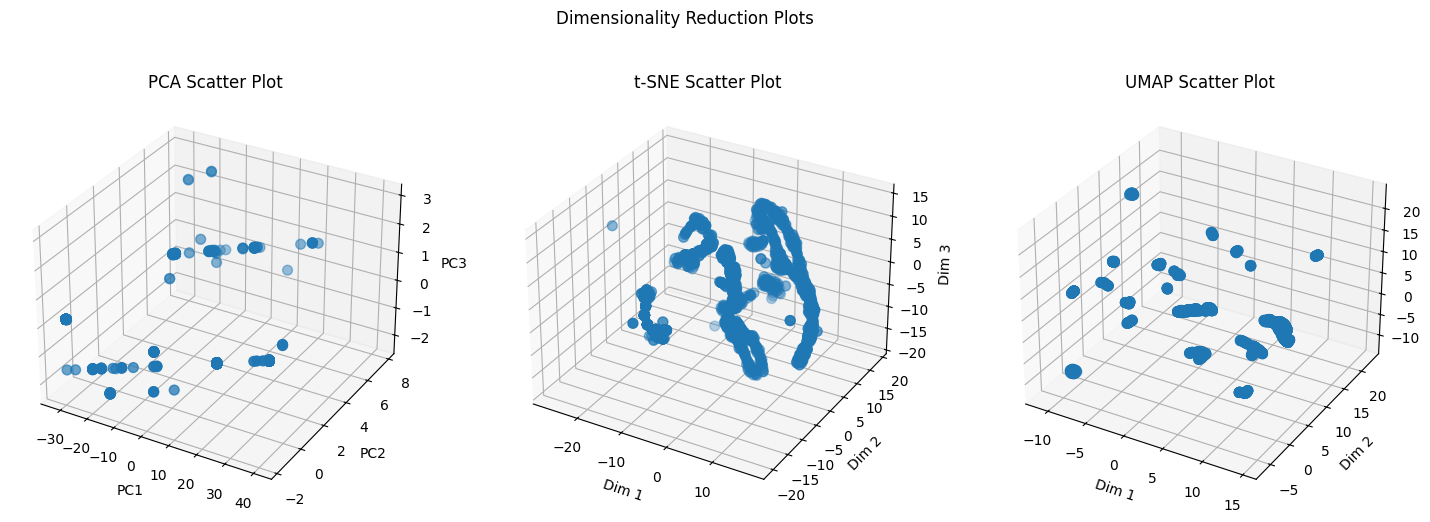

In [35]:
fig = plt.figure(figsize=(18, 6))
i = 0
# Plot PCA
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(pca_reduced_data[:, 0], pca_reduced_data[:, 1], pca_reduced_data[:, 2], s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f'PCA Scatter Plot')

# Plot t-SNE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(tsne_reduced_data[:, 0], tsne_reduced_data[:, 1], tsne_reduced_data[:, 2], s=50)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.set_title(f't-SNE Scatter Plot')

# Plot UMAP
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(umap_reduced_data[:, 0], umap_reduced_data[:, 1], umap_reduced_data[:, 2], s=50)
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.set_title(f'UMAP Scatter Plot')

plt.suptitle(f'Dimensionality Reduction Plots')
plt.show()

#### PCA, tSNE, uMAP on sequences of 3 observations

In [89]:
# random sample of original dataset, done for feasibility
merged_normal_reduced = merged_normal.sample(1000, random_state=42).reset_index(drop=True)
merged_anomalous_reduced = merged_anomalous.sample(100, random_state=42).reset_index(drop=True)
merged_silent_reduced = merged_silent.sample(100, random_state=42).reset_index(drop=True)

In [37]:
r = ReduceDim.ReduceDim(3, merged_normal_reduced, [0, 0])

merged_pca_reduced_data = r.pca()
merged_tsne_reduced_data = r.tsne()
merged_umap_reduced_data = r.umap()

# reduce with previous umap the anomalous data points
merged_umap_anomalous = r.test_umap(merged_anomalous_reduced)
merged_umap_silent = r.test_umap(merged_silent_reduced)

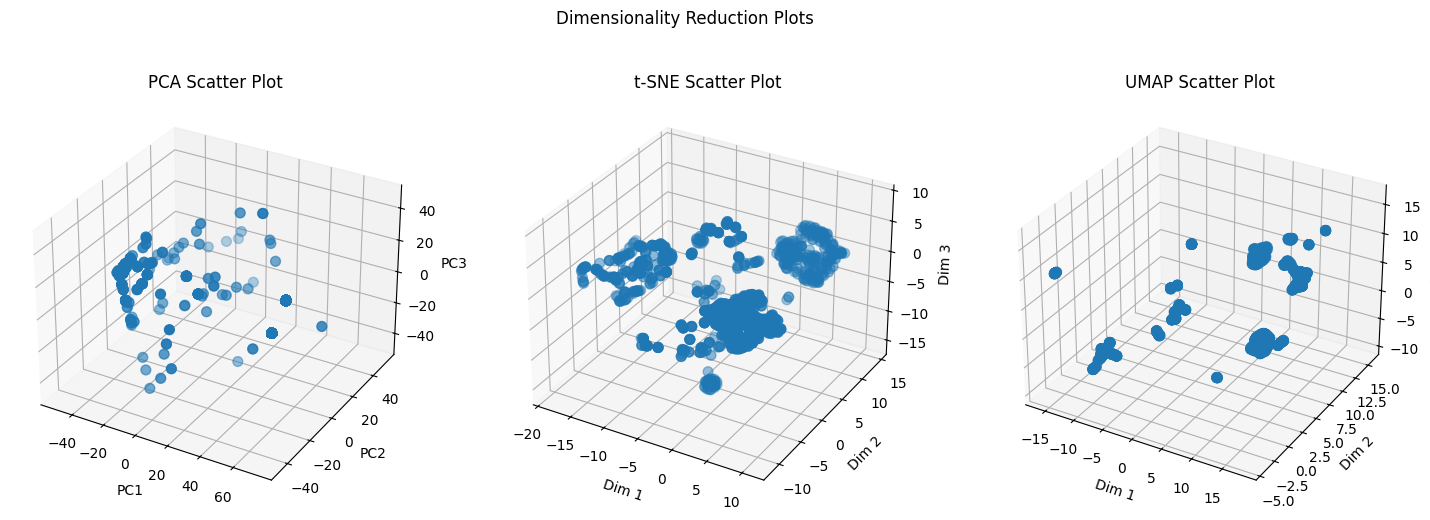

In [38]:
fig = plt.figure(figsize=(18, 6))
i = 0
# Plot PCA
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(merged_pca_reduced_data[:, 0], merged_pca_reduced_data[:, 1], merged_pca_reduced_data[:, 2], s=50)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title(f'PCA Scatter Plot')

# Plot t-SNE
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(merged_tsne_reduced_data[:, 0], merged_tsne_reduced_data[:, 1], merged_tsne_reduced_data[:, 2], s=50)
ax2.set_xlabel('Dim 1')
ax2.set_ylabel('Dim 2')
ax2.set_zlabel('Dim 3')
ax2.set_title(f't-SNE Scatter Plot')

# Plot UMAP
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(merged_umap_reduced_data[:, 0], merged_umap_reduced_data[:, 1], merged_umap_reduced_data[:, 2], s=50)
ax3.set_xlabel('Dim 1')
ax3.set_ylabel('Dim 2')
ax3.set_zlabel('Dim 3')
ax3.set_title(f'UMAP Scatter Plot')

plt.suptitle(f'Dimensionality Reduction Plots')
plt.show()

### Anomaly Detection Time Independent

#### Isolation Forest on single observations (normal vs anomalous)

In [39]:
# creation of artificial anomaly data point
labels_single = np.concatenate([np.ones(umap_anomalous.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data_single = np.vstack((umap_anomalous, umap_reduced_data))

labels_silent_single = np.concatenate([np.ones(umap_silent.shape[0]), np.zeros(umap_reduced_data.shape[0])])
new_data_silent_single = np.vstack((umap_silent, umap_reduced_data))

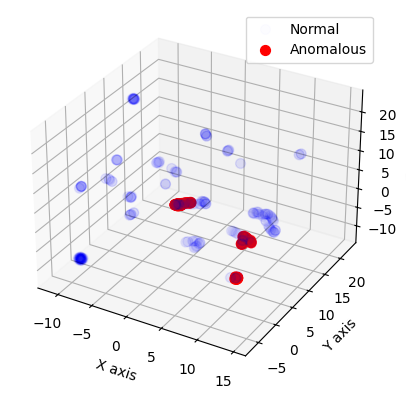

In [41]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data_single[labels_single == 0][:, 0], new_data_single[labels_single == 0][:, 1], new_data_single[labels_single == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

ax.scatter(new_data_single[labels_single == 1][:, 0], new_data_single[labels_single == 1][:, 1], new_data_single[labels_single == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [42]:
d = DetectAnomaly.DetectAnomaly(new_data_single, plots=[1,0])
anomaly_scores = d.isolation_forest()

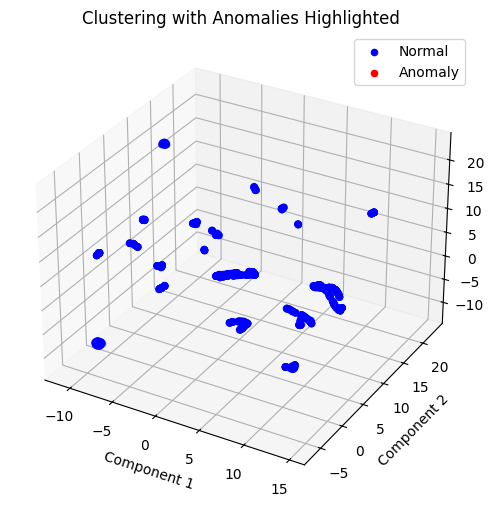

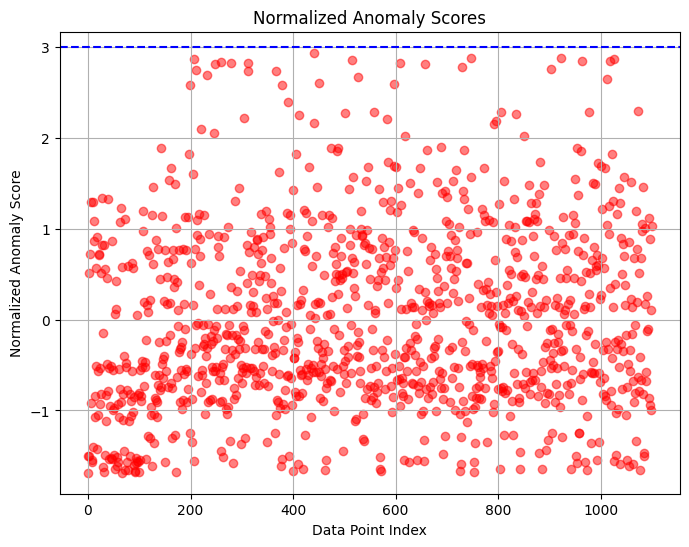

In [43]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on single observations (normal vs silent)

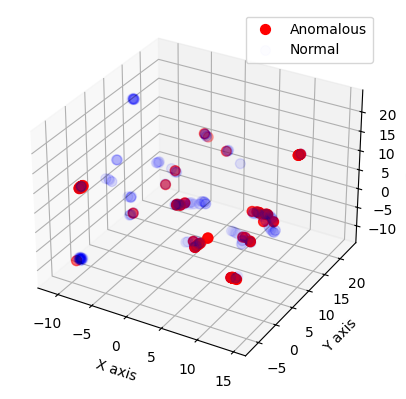

In [44]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data_silent_single[labels_silent_single == 1][:, 0], new_data_silent_single[labels_silent_single == 1][:, 1], new_data_silent_single[labels_silent_single == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data_silent_single[labels_silent_single == 0][:, 0], new_data_silent_single[labels_silent_single == 0][:, 1], new_data_silent_single[labels_silent_single == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [45]:
d = DetectAnomaly.DetectAnomaly(new_data_silent_single, plots=[1,0])
anomaly_scores = d.isolation_forest()

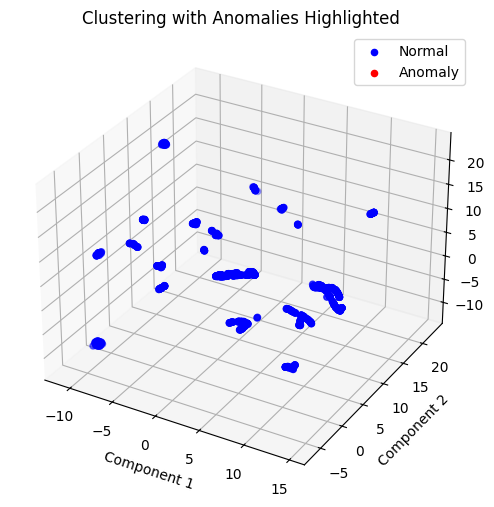

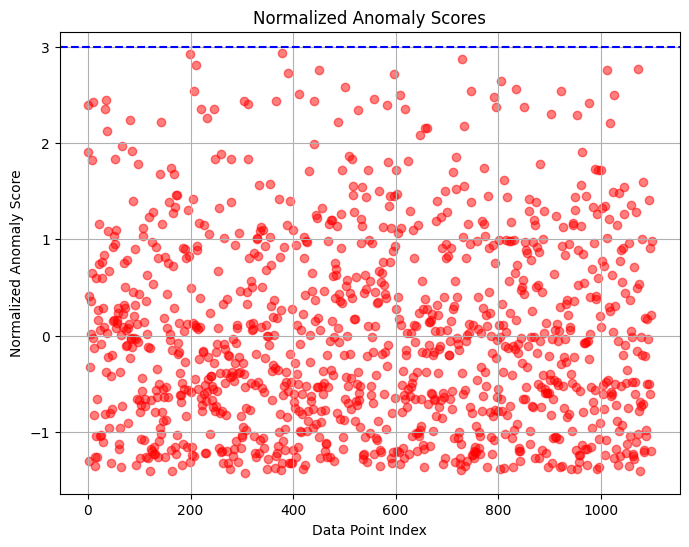

In [46]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on 3 observations (Normal vs Anomalous)

In [47]:
# reduce with previous umap the anomalous data points
merged_umap_anomalous = r.test_umap(merged_anomalous_reduced)
merged_umap_silent = r.test_umap(merged_silent_reduced)

In [48]:
# creation of artificial anomaly data point
labels_merged = np.concatenate([np.ones(merged_umap_anomalous.shape[0]), np.zeros(merged_umap_reduced_data.shape[0])])
new_data_merged = np.vstack((merged_umap_anomalous, merged_umap_reduced_data))

labels_silent_merged = np.concatenate([np.ones(merged_umap_silent.shape[0]), np.zeros(merged_umap_reduced_data.shape[0])])
new_data_silent_merged = np.vstack((merged_umap_silent, merged_umap_reduced_data))

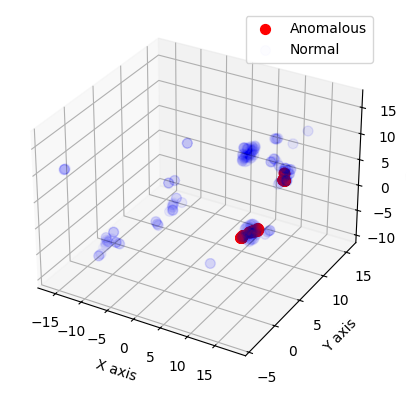

In [49]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data_merged[labels_merged == 1][:, 0], new_data_merged[labels_merged == 1][:, 1], new_data_merged[labels_merged == 1][:, 2],
           c='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data_merged[labels_merged == 0][:, 0], new_data_merged[labels_merged == 0][:, 1], new_data_merged[labels_merged == 0][:, 2], 
           c='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()


In [50]:
d = DetectAnomaly.DetectAnomaly(new_data_merged, plots=[1,0])
anomaly_scores = d.isolation_forest()

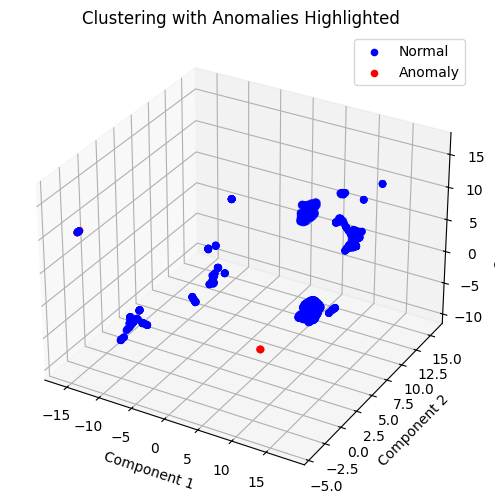

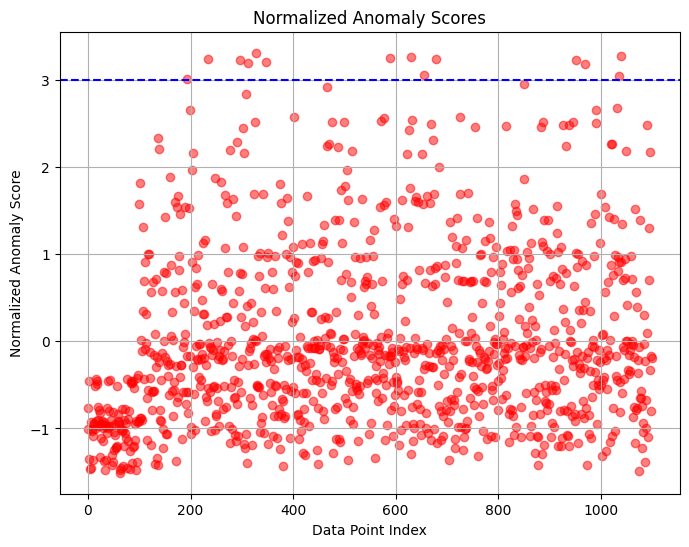

In [51]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### Isolation Forest on 3 observations (Normal vs Silent)

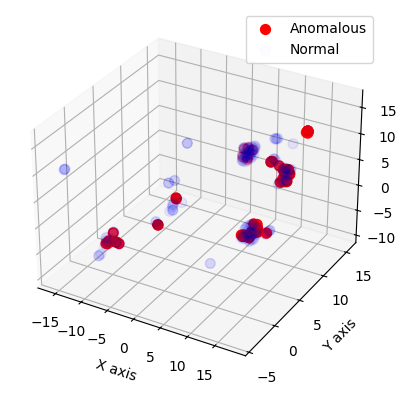

In [52]:
# 3D Scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot points, colored by label (1 for anomaly, 0 for normal)
ax.scatter(new_data_silent_merged[labels_silent_merged == 1][:, 0], new_data_silent_merged[labels_silent_merged == 1][:, 1], new_data_silent_merged[labels_silent_merged == 1][:, 2], 
           color='r', label='Anomalous', s=50)  # Red for anomalies

ax.scatter(new_data_silent_merged[labels_silent_merged == 0][:, 0], new_data_silent_merged[labels_silent_merged == 0][:, 1], new_data_silent_merged[labels_silent_merged == 0][:, 2], 
           color='b', label='Normal', s=50, alpha=0.01)  # Blue for normal points

# Add labels and legend
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.legend()

# Show the plot
plt.show()

In [53]:
d = DetectAnomaly.DetectAnomaly(new_data_silent_merged, plots=[1,0])
anomaly_scores = d.isolation_forest()

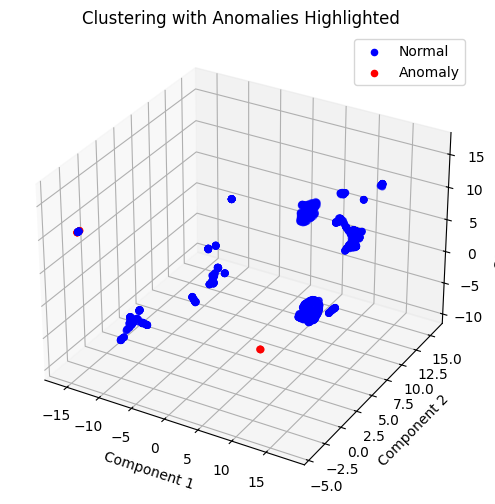

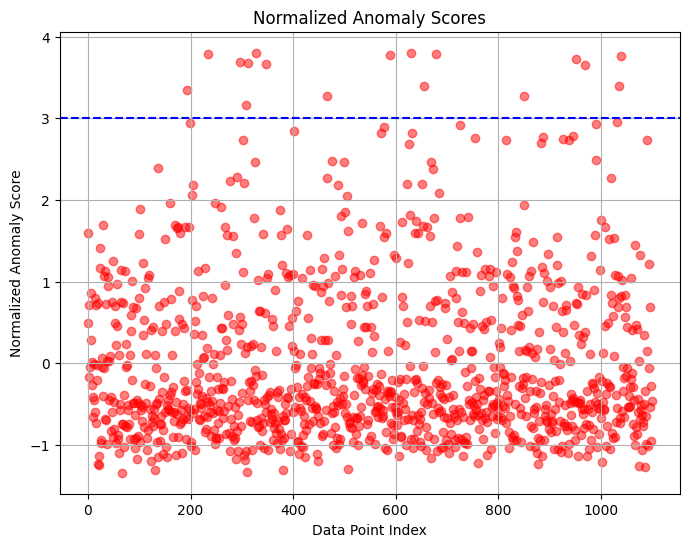

In [54]:
threshold = 0.03
anomaly_indices, anomaly_data_points = d.find_anomalies(anomaly_scores)

#### PyOD

In [55]:
# Original datasets
# umap_reduced_data
# umap_anomalous
# umap_silent

# Datasets with anomalies
# new_data_single, labels_single
# new_data_silent_single, labels_silent_single
# new_data_merged, labels_merged
# new_data_silent_merged, labels_silent_merged

We will train our anomaly detection models on the normal data, and test them on anomalous execution and silent execution.

In [68]:
# Import necessary libraries
import numpy as np
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.abod import ABOD
from pyod.models.pca import PCA
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
#from pyod.models.auto_encoder import AutoEncoder

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


In [69]:
def test_top_pyod_models(new_data, labels):
    """
    Tests the top 10 PyOD models for anomaly detection and outputs model names and accuracies.

    Parameters:
    - new_data: numpy array or pandas DataFrame containing the features.
    - labels: numpy array containing ground truth anomaly labels (0 for normal, 1 for anomaly).
    
    Returns:
    - results: List of tuples containing model names and their corresponding accuracies.
    """
    # Define the models to test
    models = {
        "KNN": KNN(),
        "LOF": LOF(),
        "IForest": IForest(),
        "ABOD": ABOD(),
        "PCA": PCA(),
        "CBLOF": CBLOF(),
        "FeatureBagging": FeatureBagging(),
        "MCD": MCD(),
        "OCSVM": OCSVM()
        #"AutoEncoder": AutoEncoder()
    }

    results = []

    # Test each model
    for name, model in models.items():
        # Fit the model
        model.fit(new_data)
        
        # Get predictions (1 for anomaly, 0 for normal)
        predictions = model.predict(new_data)
        
        # Calculate accuracy
        accuracy = accuracy_score(labels, predictions)
        results.append((name, accuracy))
        print(f"Model: {name}, Accuracy: {accuracy:.4f}")
        print("Accuracy:", accuracy_score(labels, predictions))
        print("\nClassification Report:\n", classification_report(labels, predictions))
        print("\nConfusion Matrix:\n", confusion_matrix(labels, predictions))

    return results

In [63]:
# Example usage
# Assuming new_data is a 2D array or pandas DataFrame and labels is a 1D array
print('='*20)
print(f'Testing on anomalous data, single obs')
results = test_top_pyod_models(new_data_single, labels_single)
print('='*20)
print(f'Testing on silent data, single obs')
results = test_top_pyod_models(new_data_silent_single, labels_silent_single)
print('='*20)
print(f'Testing on anomalous data, 3 obs')
results = test_top_pyod_models(new_data_merged, labels_merged)
print('='*20)
print(f'Testing on silent data, 3 obs')
results = test_top_pyod_models(new_data_silent_merged, labels_silent_merged)

Testing on anomalous data, single obs
Model: KNN, Accuracy: 0.8691
Accuracy: 0.8690909090909091

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      1000
         1.0       0.13      0.08      0.10       100

    accuracy                           0.87      1100
   macro avg       0.52      0.51      0.51      1100
weighted avg       0.84      0.87      0.85      1100


Confusion Matrix:
 [[948  52]
 [ 92   8]]
Model: LOF, Accuracy: 0.8127
Accuracy: 0.8127272727272727

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      1000
         1.0       0.00      0.00      0.00       100

    accuracy                           0.81      1100
   macro avg       0.45      0.45      0.45      1100
weighted avg       0.82      0.81      0.82      1100


Confusion Matrix:
 [[894 106]
 [100   0]]
Model: IForest, Accuracy: 0.8091
Accuracy: 0.80909090909

#### PyOD (no dim red)

In [90]:
# creation of artificial anomaly data point
labels_single = np.concatenate([np.ones(anomalous_reduced.shape[0]), np.zeros(normal_reduced.shape[0])])
new_data_single = np.vstack((anomalous_reduced, normal_reduced))

labels_silent_single = np.concatenate([np.ones(silent_reduced.shape[0]), np.zeros(normal_reduced.shape[0])])
new_data_silent_single = np.vstack((silent_reduced, normal_reduced))

# creation of artificial anomaly data point
labels_merged = np.concatenate([np.ones(merged_anomalous_reduced.shape[0]), np.zeros(merged_normal_reduced.shape[0])])
new_data_merged = np.vstack((merged_anomalous_reduced, merged_normal_reduced))

labels_silent_merged = np.concatenate([np.ones(merged_silent_reduced.shape[0]), np.zeros(merged_normal_reduced.shape[0])])
new_data_silent_merged = np.vstack((merged_silent_reduced, merged_normal_reduced))

In [92]:
# Example usage
# Assuming new_data is a 2D array or pandas DataFrame and labels is a 1D array
print('='*20)
print(f'Testing on anomalous data, single obs')
results = test_top_pyod_models(new_data_single, labels_single)
print('='*20)
print(f'Testing on silent data, single obs')
results = test_top_pyod_models(new_data_silent_single, labels_silent_single)
print('='*20)
print(f'Testing on anomalous data, 3 obs')
results = test_top_pyod_models(new_data_merged, labels_merged)
print('='*20)
print(f'Testing on silent data, 3 obs')
results = test_top_pyod_models(new_data_silent_merged, labels_silent_merged)

Testing on anomalous data, single obs
Model: KNN, Accuracy: 0.8255
Accuracy: 0.8254545454545454

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.90      1000
         1.0       0.00      0.00      0.00       100

    accuracy                           0.83      1100
   macro avg       0.45      0.45      0.45      1100
weighted avg       0.82      0.83      0.82      1100


Confusion Matrix:
 [[908  92]
 [100   0]]
Model: LOF, Accuracy: 0.8309
Accuracy: 0.8309090909090909

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.91      0.91      1000
         1.0       0.00      0.00      0.00       100

    accuracy                           0.83      1100
   macro avg       0.45      0.46      0.45      1100
weighted avg       0.82      0.83      0.83      1100


Confusion Matrix:
 [[914  86]
 [100   0]]
Model: IForest, Accuracy: 0.8291
Accuracy: 0.82909090909

### Anomaly Detection Time Dependent

#### Markov Chains

In [36]:
from hmmlearn import hmm

In [37]:
def train_model(data, n_components=3):
    """
    Train a Hidden Markov Model (HMM) on the given time series data.
    
    Parameters:
    - data: array-like, shape (n_samples, n_features)
        The input time series data to train on.
    - n_components: int, optional (default=3)
        The number of hidden states in the HMM.
    
    Returns:
    - model: trained HMM model
    """
    # Reshape data to fit HMM
    data = np.array(data).reshape(-1, 1)  # Assuming data is one-dimensional

    # Create and fit the HMM
    model = hmm.GaussianHMM(n_components=n_components, covariance_type="full", n_iter=1000)
    model.fit(data)

    return model

def test_model(model, data, threshold=0.01):
    """
    Perform anomaly detection using the trained HMM model.
    
    Parameters:
    - model: trained HMM model
    - data: array-like, shape (n_samples, n_features)
        The input time series data to test for anomalies.
    - threshold: float, optional (default=0.01)
        The likelihood threshold below which a sequence is considered an anomaly.
    
    Returns:
    - anomalies: list of indices where anomalies were detected.
    - likelihoods: log-likelihoods of the input data.
    """
    # Reshape data to fit HMM
    data = np.array(data).reshape(-1, 1)  # Assuming data is one-dimensional

    # Calculate likelihood for each data point
    likelihoods = np.array([model.score(data[i:i + 1]) for i in range(len(data))])

    # Detect anomalies
    anomalies = np.where(likelihoods < threshold)[0]

    return anomalies, likelihoods

In [39]:
# Generate synthetic normal data
np.random.seed(42)
normal_data = normal_
anomalous_data = anomalous_
silent_data = silent_

# Train the model
model = train_model(normal_data, n_components=3)

Model is not converging.  Current: -973417.8658682697 is not greater than -973297.1935496737. Delta is -120.67231859604362


Detected anomalies at indices: [     1      8     10 ... 899981 899990 899999]
Log likelihoods of the data: [  0.54925298 -42.84314067  -4.90818579 ...   0.54925298   0.54925298
 -81.15916705]


NameError: name 'detected_anomalies_an' is not defined

In [42]:
# Test the model for anomalies
detected_anomalies, likelihoods = test_model(model, normal_data, threshold=-5)
# Output results
print(f"Detected {len(detected_anomalies)} anomalies")
#print("Detected anomalies at indices:", detected_anomalies)
print("Log likelihoods of the data:", likelihoods)

detected_anomalies_an, likelihoods_an = test_model(model, anomalous_data, threshold=-5)
# Output results
print(f"Detected {len(detected_anomalies_an)} anomalies")
#print("Detected anomalies at indices:", detected_anomalies_an)
print("Log likelihoods of the data:", likelihoods_an)

detected_anomalies_silent, likelihoods_silent = test_model(model, silent_data, threshold=-5)
# Output results
print(f"Detected {len(detected_anomalies_silent)} anomalies")
#print("Detected anomalies at indices:", detected_anomalies_silent)
print("Log likelihoods of the data:", likelihoods_silent)

Detected 199862 anomalies
Log likelihoods of the data: [  0.54925298 -42.84314067  -4.90818579 ...   0.54925298   0.54925298
 -81.15916705]
Detected 3032 anomalies
Log likelihoods of the data: [-52.62073416  -9.07664625  -2.88950534 ...   0.54925298   0.54925298
 -84.11757278]
Detected 83555 anomalies
Log likelihoods of the data: [   0.54925298  -42.84314067   -0.78843314 ...  -81.07322979    0.54925298
 -205.80365417]


## DL Time Independent

### Normal vs Anomalous (secure)

In [ ]:
# see summary 6 to 9

### Normal vs Anomalous (laurel)

Mean normal reconstruction error: 0.01499112094235114
Mean anomalous reconstruction error: 0.03699694298280672


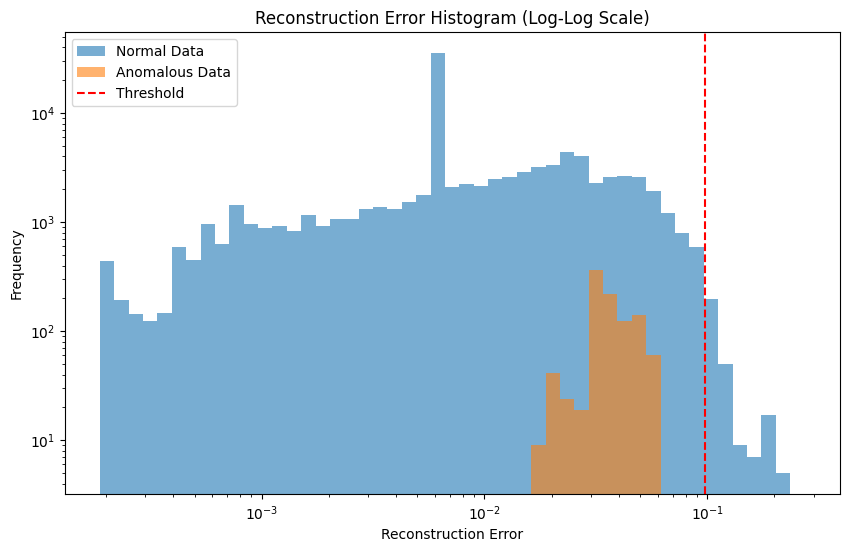

Threshold for anomaly detection: 0.09812170245322219
Number of anomalies detected: 0
Number of false positives detected: 250


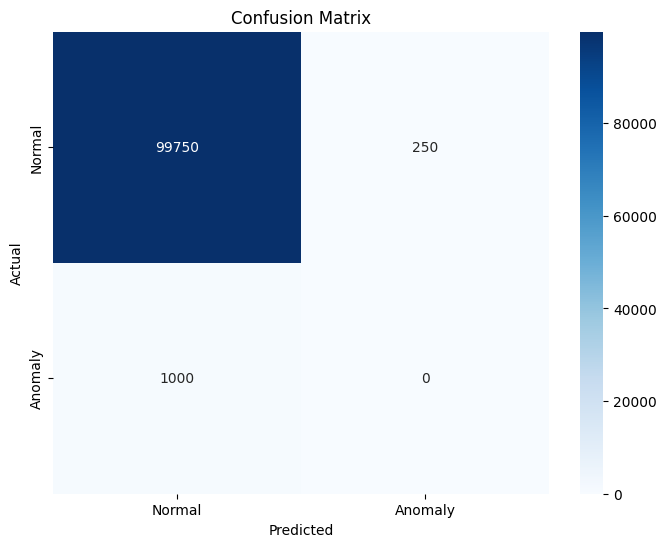

In [38]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, anomalous_, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Anomalous (sequences of 3)

Mean normal reconstruction error: 0.011670057832290973
Mean anomalous reconstruction error: 0.03709298753400388


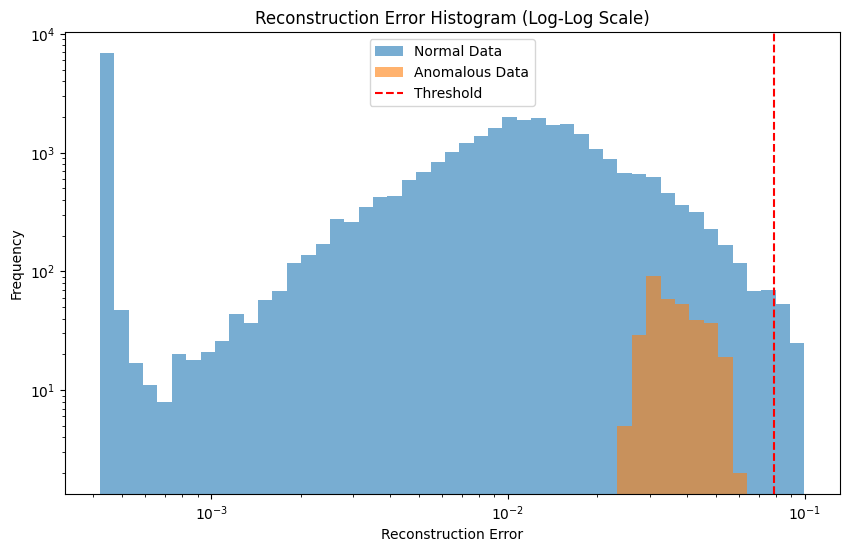

Threshold for anomaly detection: 0.07884219131840499
Number of anomalies detected: 0
Number of false positives detected: 84


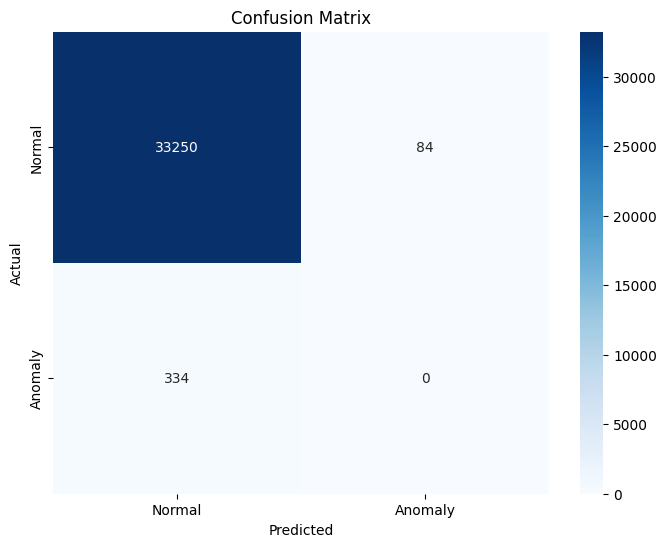

In [64]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(merged_normal, merged_anomalous, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Silent (laurel)

Mean normal reconstruction error: 0.0089816216930396
Mean anomalous reconstruction error: 227551.41421392027


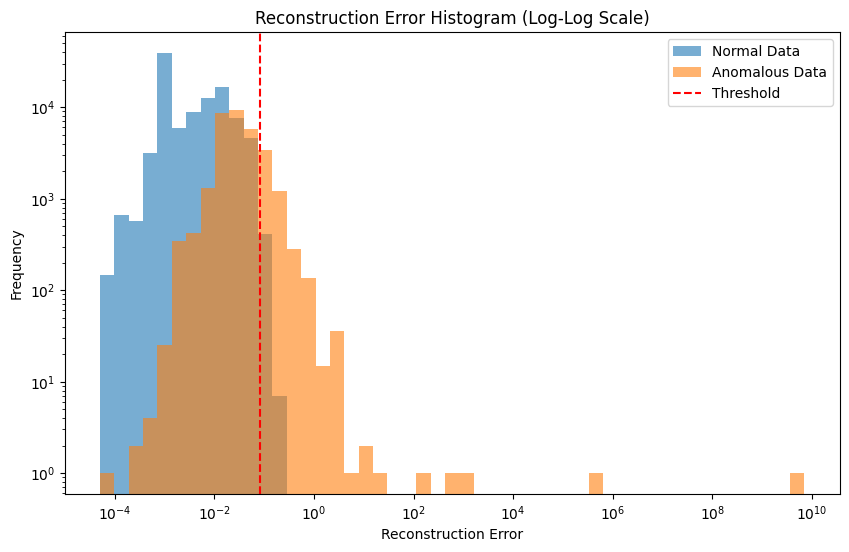

Threshold for anomaly detection: 0.08397678434146842
Number of anomalies detected: 4836
Number of false positives detected: 250


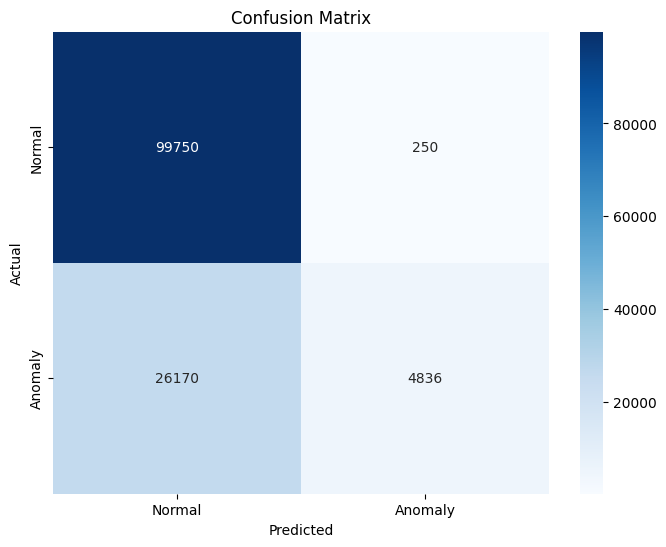

In [39]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_, silent_, 'autoencoder', laurel=1, plots=[0,0,1,1])

In [40]:
# remove features
normal_small = normal_.drop(['pid', 'ppid'], axis=1)
silent_small = silent_.drop(['pid', 'ppid'], axis=1)

Mean normal reconstruction error: 0.00022698968015582593
Mean anomalous reconstruction error: 292564.23281843215


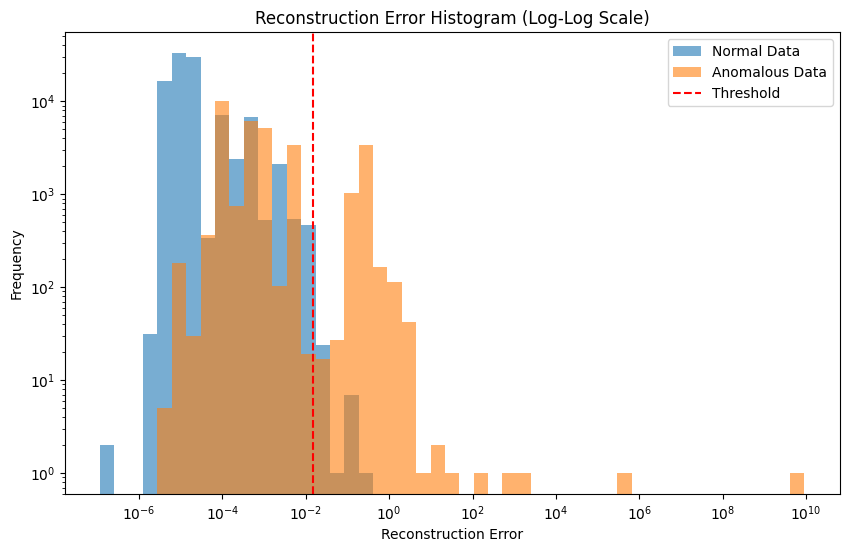

Threshold for anomaly detection: 0.014646855427975464
Number of anomalies detected: 4802
Number of false positives detected: 59


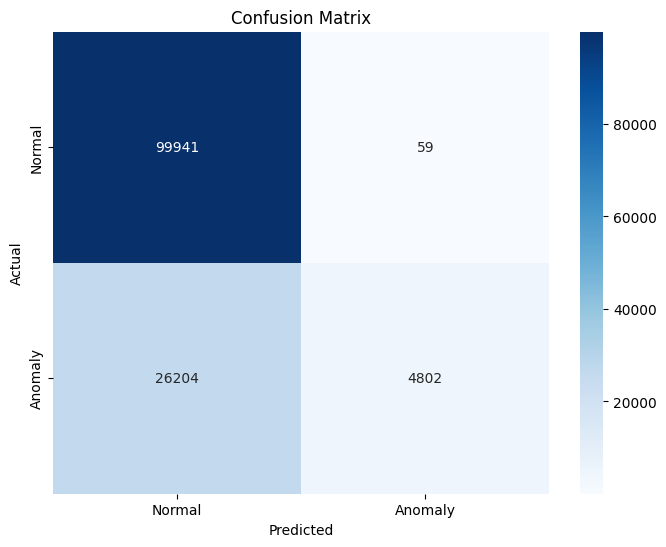

In [41]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_small, silent_small, 'autoencoder', laurel=1, plots=[0,0,1,1])

### Normal vs Silent (Sequences of 3)

Mean normal reconstruction error: 0.01578643420840785
Mean anomalous reconstruction error: 227621.2485622029


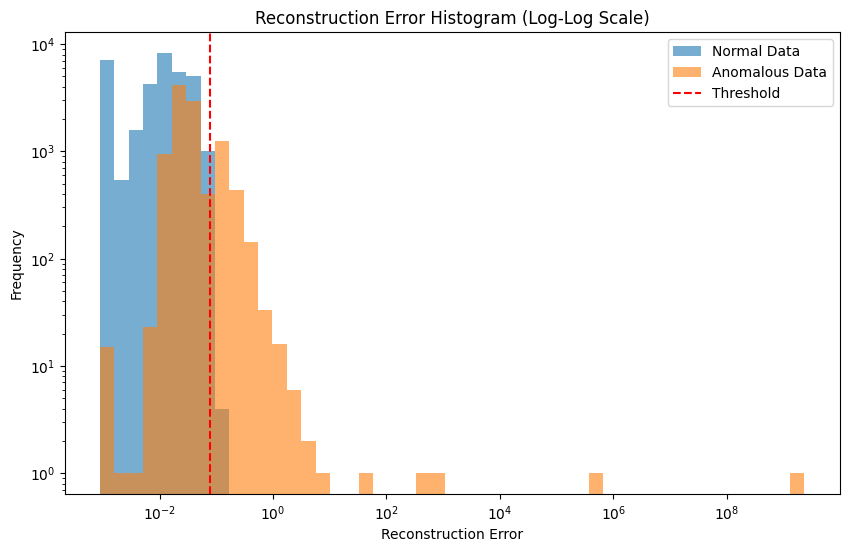

Threshold for anomaly detection: 0.07741846949073236
Number of anomalies detected: 1934
Number of false positives detected: 84


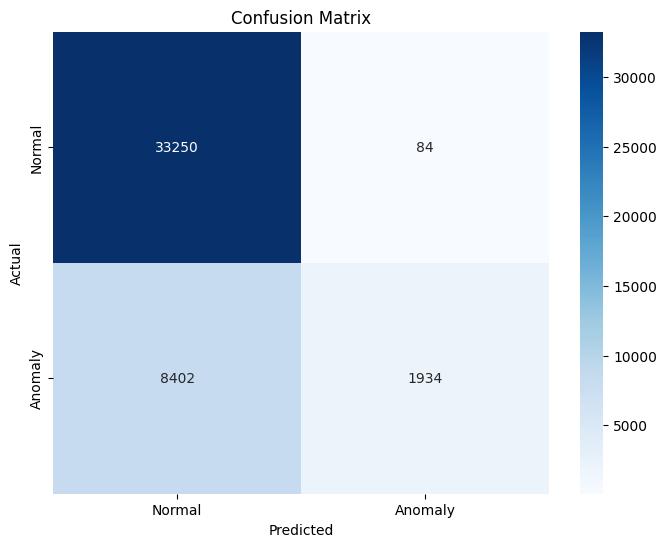

In [65]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(merged_normal, merged_silent, 'autoencoder', laurel=1, plots=[0,0,1,1])

## DL Time Dependent

### MLP

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       115,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 27)             │         3,483 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 3, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 151,835 (593.11 KB)

 Trainable params: 151,835 (593.11 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0457 - mae: 0.1354 - val_loss: 0.0146 - val_mae: 0.0677
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248 - mae: 0.0894 - val_loss: 0.0143 - val_mae: 0.0642
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0234 - mae: 0.0842 - val_loss: 0.0139 - val_mae: 0.0605
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0225 - mae: 0.0806 - val_loss: 0.0138 - val_mae: 0.0600
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0217 - mae: 0.0781 - val_loss: 0.0134 - val_mae: 0.0566
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0211 - mae: 0.0763 - val_loss: 0.0134 - val_mae: 0.0572
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0206 - mae: 0.0751 - val_loss: 0.0133 - val_mae: 0.0554
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0200 - mae: 0.0735 - val_loss: 0.0135 - val_mae: 0.0567
Epoch 9/2000
200/200 ━━━━━━━━━━━━━━━━━━━

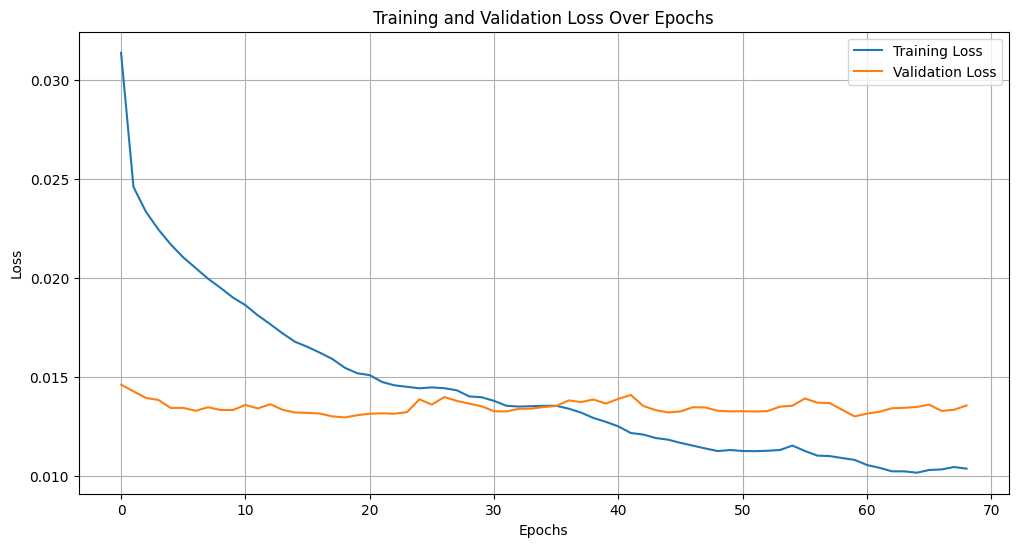

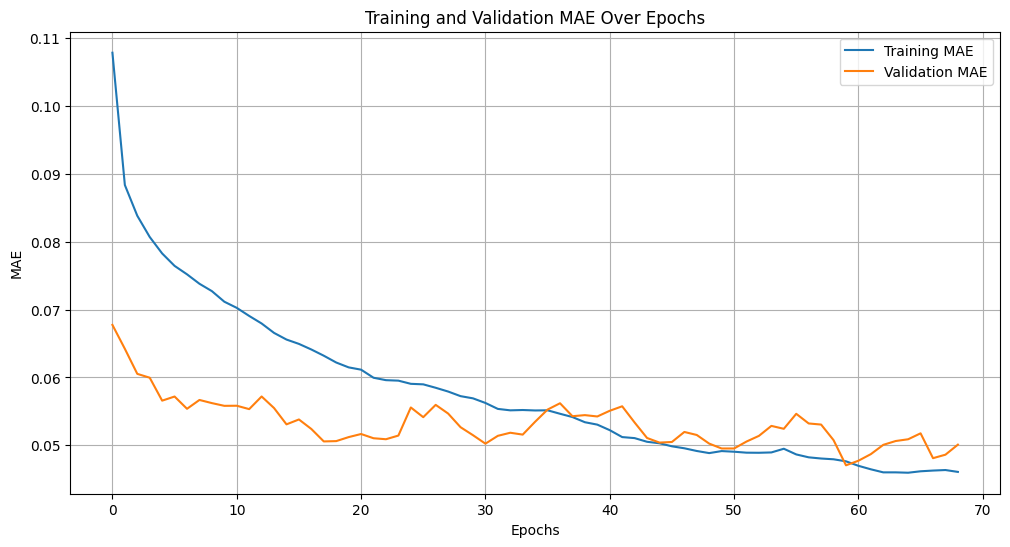

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - loss: 0.0186 - mae: 0.0626
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Test Loss: 0.024200208485126495
Test MAE: 0.0749078243970871


In [93]:
# to complete
t = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
test_loss, test_mae = t.detect_anomalies(normal_, verbose=1)

In [94]:
print(test_loss, test_mae)

0.024200208485126495 0.0749078243970871


In [95]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0950 - mae: 0.2306 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [96]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step - loss: 0.0653 - mae: 0.1828
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step


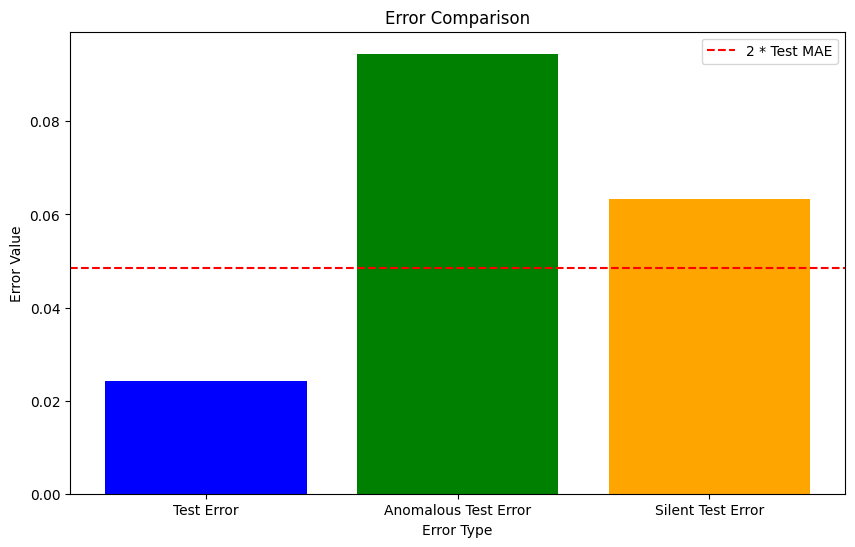

In [97]:
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

mlp_perf = [test_loss, test_loss_anomalous, test_loss_silent]

# Labels and values
labels = ['Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Add a horizontal line at 2 * test_error
plt.axhline(y=2 * test_error, color='red', linestyle='--', label='2 * Test MAE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Simple 1D CNN

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_11 (Conv1D)              │ (None, 50, 128)        │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 50, 64)         │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 50, 9)          │         1,737 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 3, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,961 (117.04 KB)

 Trainable params: 29,961 (117.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0431 - mae: 0.1265 - val_loss: 0.0134 - val_mae: 0.0549
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0232 - mae: 0.0769 - val_loss: 0.0134 - val_mae: 0.0542
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0225 - mae: 0.0742 - val_loss: 0.0134 - val_mae: 0.0544
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0221 - mae: 0.0727 - val_loss: 0.0135 - val_mae: 0.0548
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0217 - mae: 0.0715 - val_loss: 0.0135 - val_mae: 0.0545
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0213 - mae: 0.0705 - val_loss: 0.0135 - val_mae: 0.0546
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0210 - mae: 0.0695 - val_loss: 0.0135 - val_mae: 0.0542
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0207 - mae: 0.0686 - val_loss: 0.0134 - val_mae: 0.0534
Epoch 9/2000
200/200 ━━━━━━━━━━━━━━━━━━━

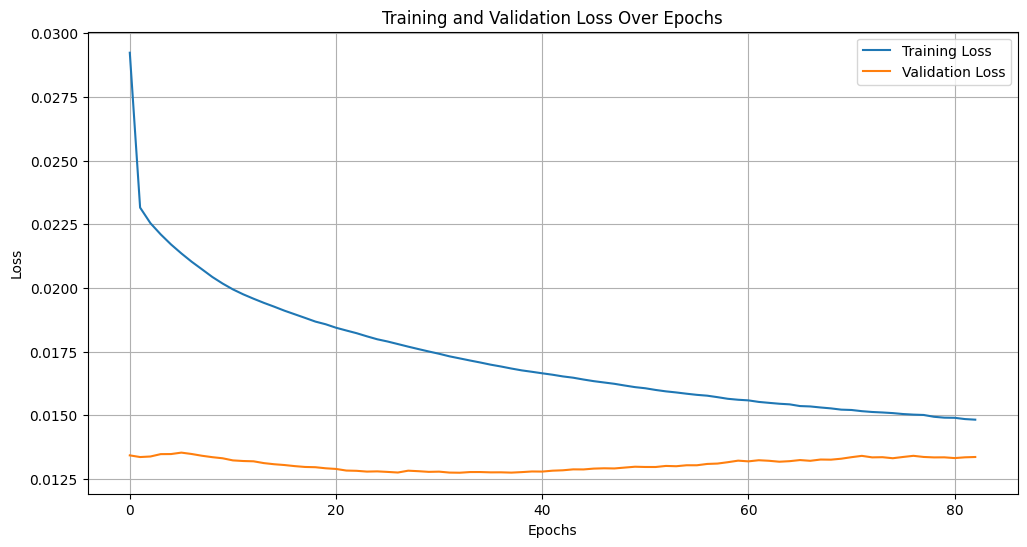

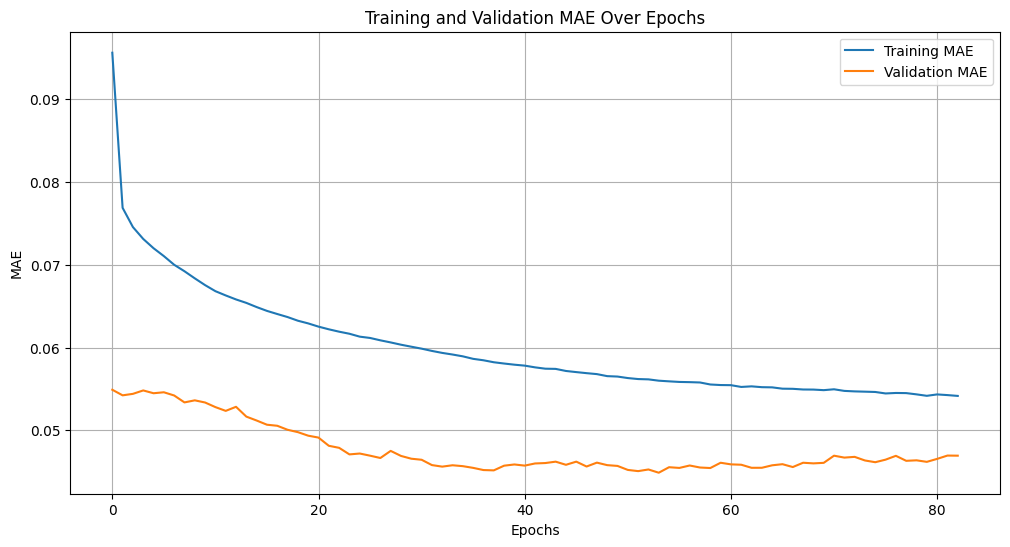

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0158 - mae: 0.0539
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test Loss: 0.01932021602988243
Test MAE: 0.06289223581552505


In [98]:
# to complete
t = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
test_loss, test_mae = t.detect_anomalies_1DCNN(normal_, verbose=1)

In [99]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1394 - mae: 0.2674 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [100]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0607 - mae: 0.1697
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


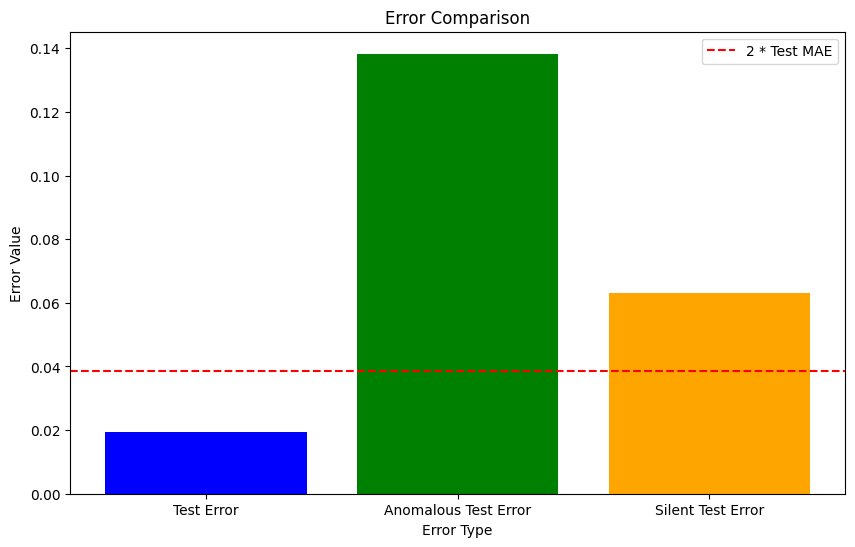

In [101]:
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

cnn_perf = [test_loss, test_loss_anomalous, test_loss_silent]

# Labels and values
labels = ['Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Add a horizontal line at 2 * test_error
plt.axhline(y=2 * test_error, color='red', linestyle='--', label='2 * Test MAE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### ResNet 1DCNN

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "functional_30"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 50, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 50, 64)    │      1,792 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 50, 64)    │     12,352 │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (None, 50, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 50, 64)    │     12,352 │ activation_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_16[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 50, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 50, 64)    │          0 │ add_3[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_17 (Conv1D)  │ (None, 50, 64)    │     12,352 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_17[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 50, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_18 (Conv1D)  │ (None, 50, 64)    │     12,352 │ activation_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_18[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 50, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 50, 64)    │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_19 (Conv1D)  │ (None, 50, 64)    │     12,352 │ activation_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 64)    │        256 │ conv1d_19[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_10       │ (None, 50, 64)    │          0 │ batch_normalizat

 Total params: 78,025 (304.79 KB)

 Trainable params: 77,257 (301.79 KB)

 Non-trainable params: 768 (3.00 KB)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 0.4690 - mae: 0.3866 - val_loss: 0.0787 - val_mae: 0.2200
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0322 - mae: 0.1161 - val_loss: 0.0225 - val_mae: 0.1048
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0272 - mae: 0.1001 - val_loss: 0.0155 - val_mae: 0.0713
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0253 - mae: 0.0931 - val_loss: 0.0149 - val_mae: 0.0653
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0242 - mae: 0.0890 - val_loss: 0.0143 - val_mae: 0.0613
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0234 - mae: 0.0861 - val_loss: 0.0140 - val_mae: 0.0601
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0228 - mae: 0.0838 - val_loss: 0.0138 - val_mae: 0.0582
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0223 - mae: 0.0820 - val_loss: 0.0138 - val_mae: 0.0578
Epoch 9/2000
200/200 ━━━━━━━━━━━

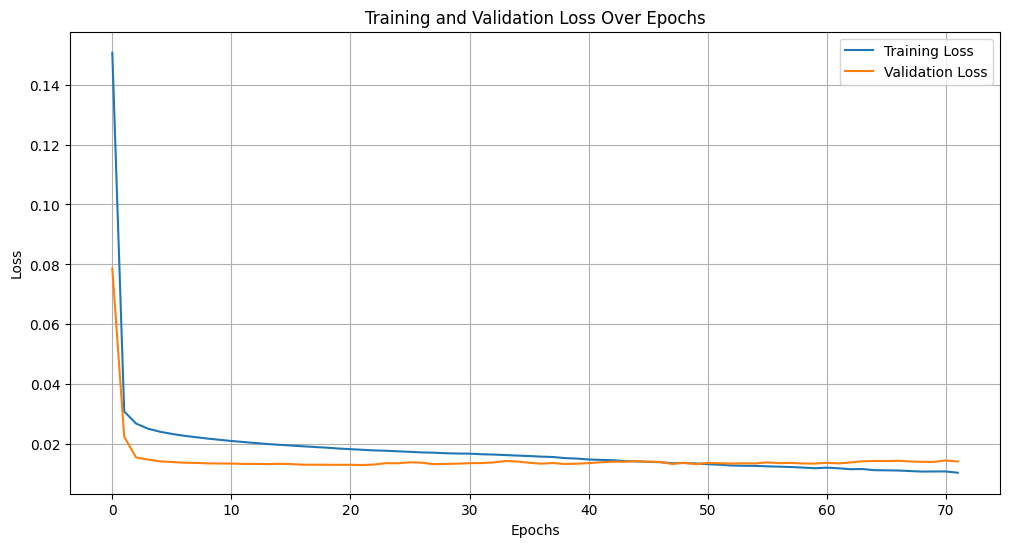

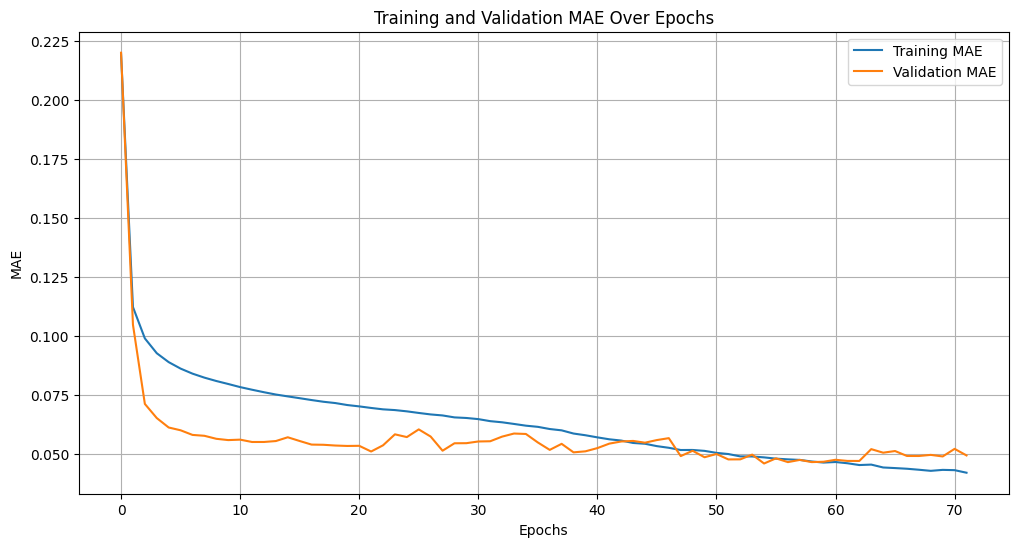

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - mae: 0.0627
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Loss: 0.02175048552453518
Test MAE: 0.07497982680797577


In [102]:
# to complete
t = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
test_loss, test_mae = t.detect_anomalies_resnet(normal_, verbose=1)

In [103]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1140 - mae: 0.2641 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [104]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0797 - mae: 0.2071
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


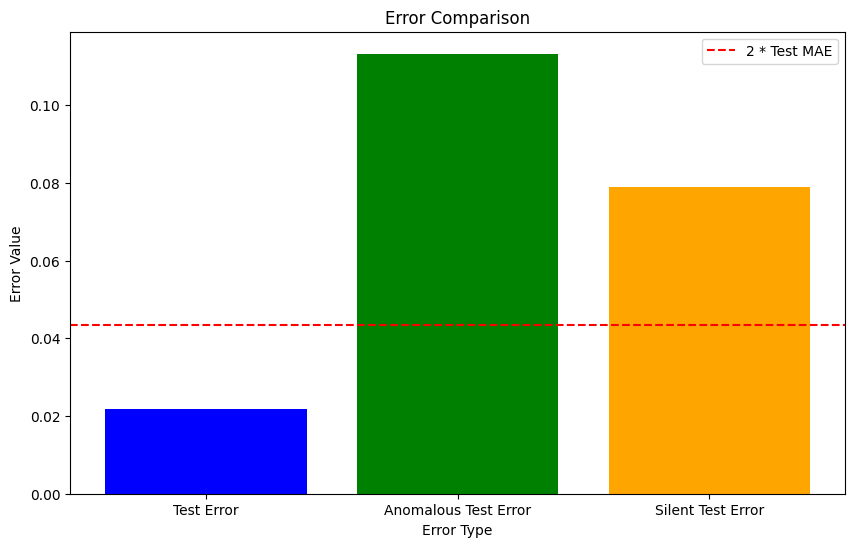

In [105]:
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

resnet_perf = [test_loss, test_loss_anomalous, test_loss_silent]

# Labels and values
labels = ['Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Add a horizontal line at 2 * test_error
plt.axhline(y=2 * test_error, color='red', linestyle='--', label='2 * Test MAE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### LSTM

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 50, 9)          │           585 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 3, 9)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 120,649 (471.29 KB)

 Trainable params: 120,649 (471.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - loss: 0.0374 - mae: 0.1091 - val_loss: 0.0148 - val_mae: 0.0628
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0252 - mae: 0.0815 - val_loss: 0.0148 - val_mae: 0.0610
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0248 - mae: 0.0799 - val_loss: 0.0145 - val_mae: 0.0607
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0244 - mae: 0.0789 - val_loss: 0.0141 - val_mae: 0.0589
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - loss: 0.0240 - mae: 0.0776 - val_loss: 0.0140 - val_mae: 0.0583
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0236 - mae: 0.0762 - val_loss: 0.0140 - val_mae: 0.0588
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 0.0231 - mae: 0.0753 - val_loss: 0.0138 - val_mae: 0.0559
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 0.0227 - mae: 0.0739 - val_loss: 0.0138 - val_mae: 0.0576
Epoch 9/2000
200/200 ━━━━━━

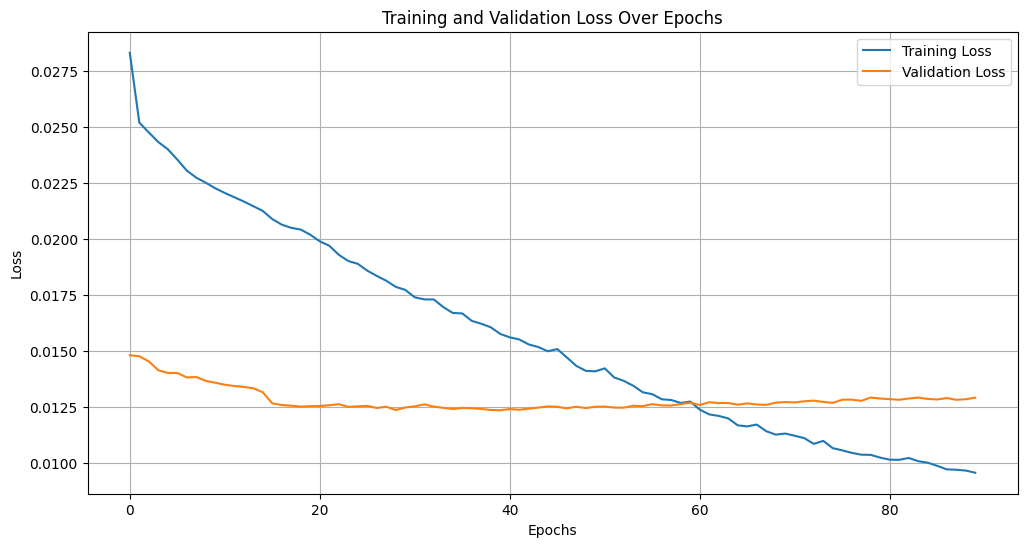

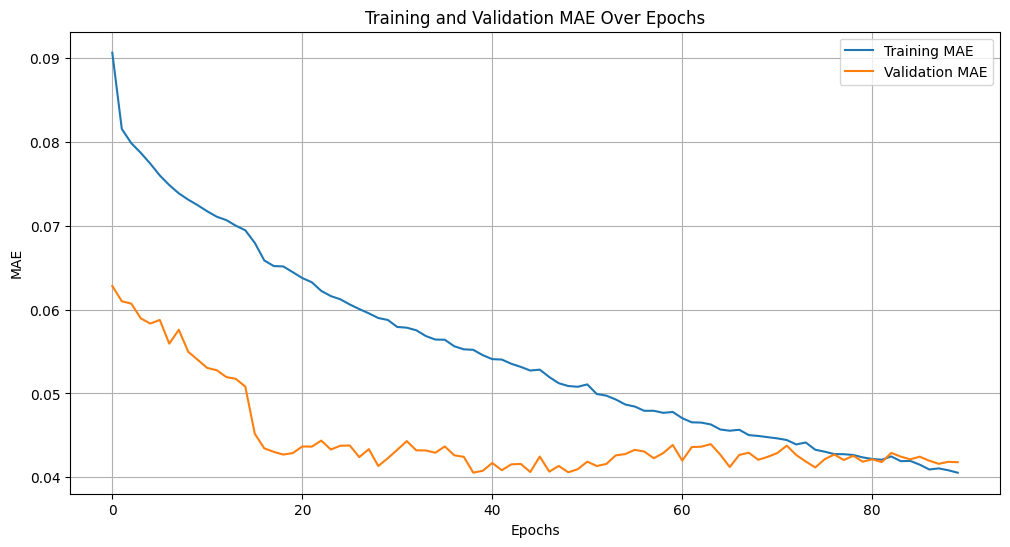

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0163 - mae: 0.0516
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
Test Loss: 0.020416563376784325
Test MAE: 0.06254542618989944


In [106]:
test_loss, test_mae = t.detect_anomalies_LSTM(normal_, verbose=1)

In [107]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1136 - mae: 0.2346
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [108]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0832 - mae: 0.1842
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


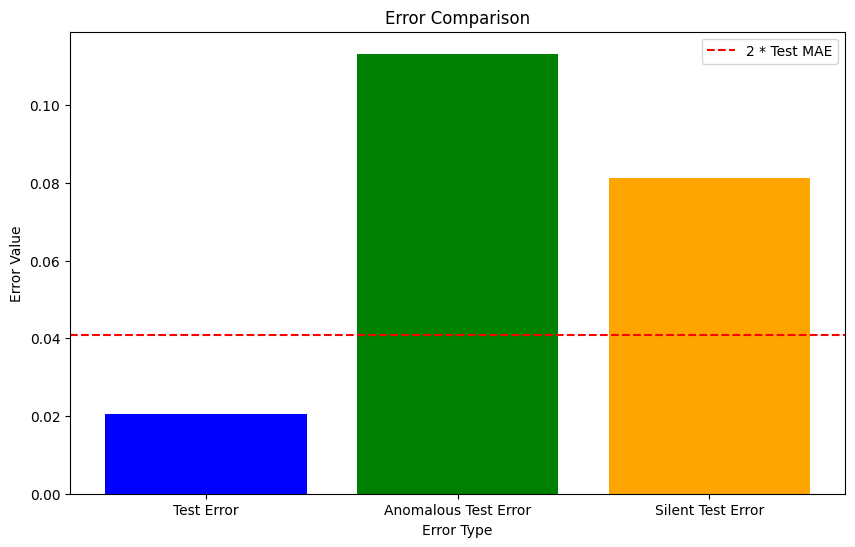

In [109]:
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

lstm_perf = [test_loss, test_loss_anomalous, test_loss_silent]

# Labels and values
labels = ['Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Add a horizontal line at 2 * test_error
plt.axhline(y=2 * test_error, color='red', linestyle='--', label='2 * Test MAE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Transformer

Train shape: (80000, 9)
Test shape: (20000, 9)


Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 50, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 50, 9)     │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 9)     │      1,413 │ add_6[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_6[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 9)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 50, 9)     │          0 │ add_6[0][0],      │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 50, 9)     │         18 │ add_7[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_22 (Conv1D)  │ (None, 50, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_23 (Conv1D)  │ (None, 50, 9)     │      1,161 │ conv1d_22[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 50, 9)     │          0 │ conv1d_23[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 50, 9)     │      1,413 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 50, 9)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_24 (Conv1D)  │ (None, 50, 128)   │      1,280 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_25 (Conv1D)  │ (None, 50, 9)     │      1,161 │ conv1d_24[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 50, 9)     │          0 │ conv1d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 50, 9)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 50, 9)     │         18 │ add_10[0][0]    

 Total params: 7,870 (30.74 KB)

 Trainable params: 7,870 (30.74 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 0.2159 - mae: 0.3128 - val_loss: 0.0154 - val_mae: 0.0730
Epoch 2/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0327 - mae: 0.1145 - val_loss: 0.0145 - val_mae: 0.0661
Epoch 3/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0290 - mae: 0.1025 - val_loss: 0.0144 - val_mae: 0.0668
Epoch 4/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0271 - mae: 0.0951 - val_loss: 0.0140 - val_mae: 0.0635
Epoch 5/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0261 - mae: 0.0905 - val_loss: 0.0139 - val_mae: 0.0630
Epoch 6/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0258 - mae: 0.0890 - val_loss: 0.0138 - val_mae: 0.0611
Epoch 7/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0254 - mae: 0.0871 - val_loss: 0.0135 - val_mae: 0.0557
Epoch 8/2000
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0252 - mae: 0.0859 - val_loss: 0.0134 - val_mae: 0.0559
Epoch 9/2000
200/200 ━━━━━━━━━━━

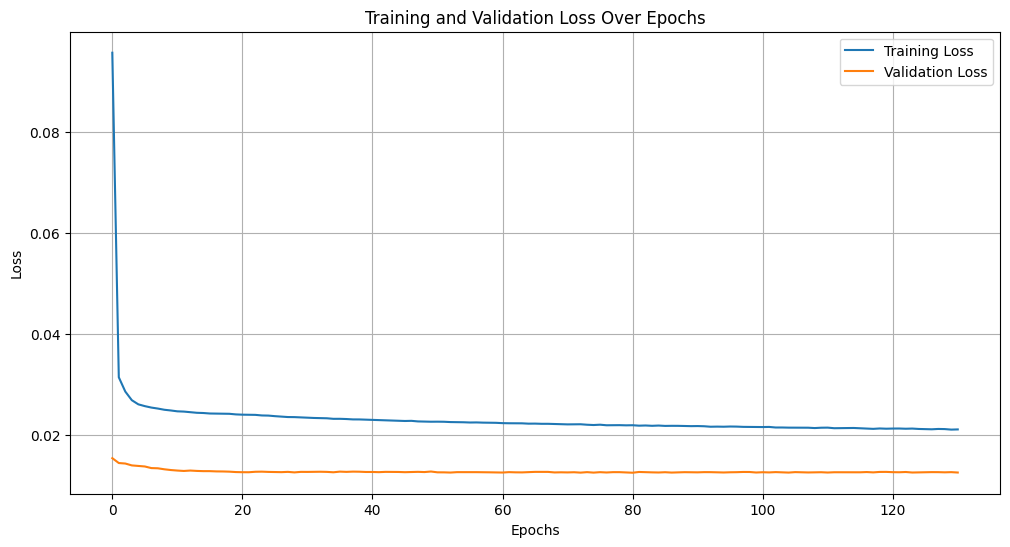

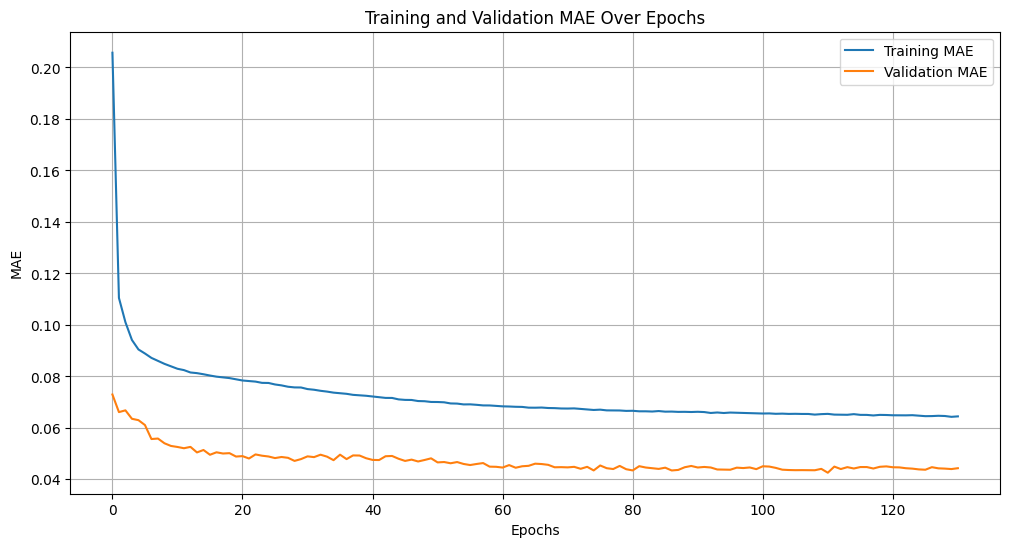

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0182 - mae: 0.0572
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Test Loss: 0.023810556158423424
Test MAE: 0.07039684057235718


In [110]:
test_loss, test_mae = t.detect_anomalies_transformer(normal_, verbose=1)

In [111]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
anomalous_max = anomalous_.max()
anomalous_min = anomalous_.min()

anomalous_ = (anomalous_ - anomalous_min) / (anomalous_max - anomalous_min)

X_anomalous, y_anomalous = t2.build_sequences(anomalous_)

X_anomalous = np.nan_to_num(X_anomalous, nan=0.0)
y_anomalous = np.nan_to_num(y_anomalous, nan=0.0)

print(X_anomalous.shape, y_anomalous.shape)

y_pred_anomalous, test_loss_anomalous, test_mae_anomalous = t.predict(X_anomalous, y_anomalous)

(95, 50, 9) (95, 3, 9)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1260 - mae: 0.2380 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


In [112]:
# t2 is the instance of test
t2 = TimeDependentDeepLearningAnomalyDetection.TimeDependentDeepLearningAnomalyDetection()
# now we test with anomalies
silent_max = silent_.max()
silent_min = silent_.min()

silent_ = (silent_ - silent_min) / (silent_max - silent_min)

X_silent, y_silent = t2.build_sequences(silent_)

X_silent = np.nan_to_num(X_silent, nan=0.0)
y_silent = np.nan_to_num(y_silent, nan=0.0)

print(X_silent.shape, y_silent.shape)

y_pred_silent, test_loss_silent, test_mae_silent = t.predict(X_silent, y_silent)

(3100, 50, 9) (3100, 3, 9)
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0949 - mae: 0.2138
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


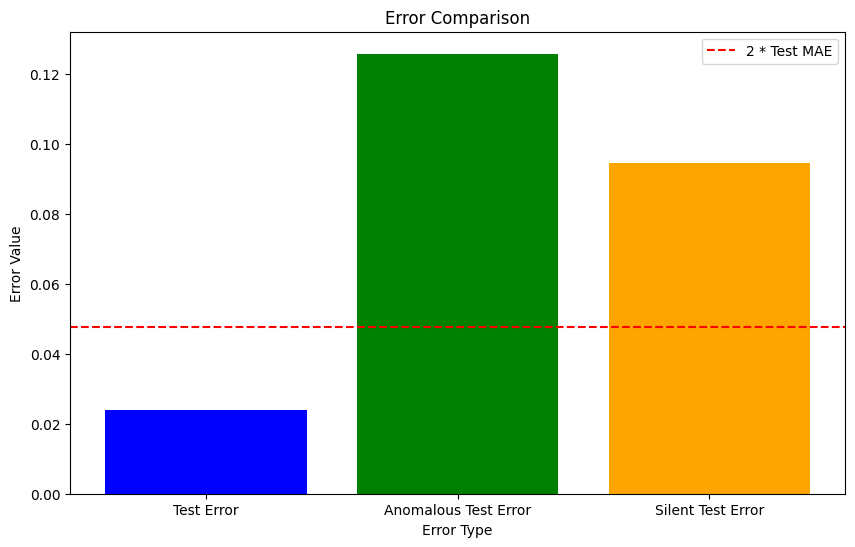

In [113]:
test_error = test_loss
anomalous_test_error = test_loss_anomalous
silent_test_error = test_loss_silent

transf_perf = [test_loss, test_loss_anomalous, test_loss_silent]

# Labels and values
labels = ['Test Error', 'Anomalous Test Error', 'Silent Test Error']
values = [test_error, anomalous_test_error, silent_test_error]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'green', 'orange'])

# Add labels and title
plt.xlabel('Error Type')
plt.ylabel('Error Value')
plt.title('Error Comparison')

# Add a horizontal line at 2 * test_error
plt.axhline(y=2 * test_error, color='red', linestyle='--', label='2 * Test MAE')

# Add a legend
plt.legend()

# Show the plot
plt.show()

### Overall performance evaluation

In [114]:
models = ['MLP', '1DCNN', '1DResNet', 'LSTM', 'Transformer']
pfs = [mlp_perf, cnn_perf, resnet_perf, lstm_perf, transf_perf]

test_perf = [pf[0] for pf in pfs]
an_perf = [pf[1] for pf in pfs]
silent_perf = [pf[2] for pf in pfs]

In [119]:
test_perf

[0.024200208485126495,
 0.01932021602988243,
 0.02175048552453518,
 0.020416563376784325,
 0.023810556158423424]

In [118]:
an_perf

[0.09452562779188156,
 0.13831691443920135,
 0.11327453702688217,
 0.11326193809509277,
 0.1258849799633026]

In [120]:
silent_perf

[0.06325971335172653,
 0.06324762850999832,
 0.07900403439998627,
 0.0812481939792633,
 0.09450942277908325]

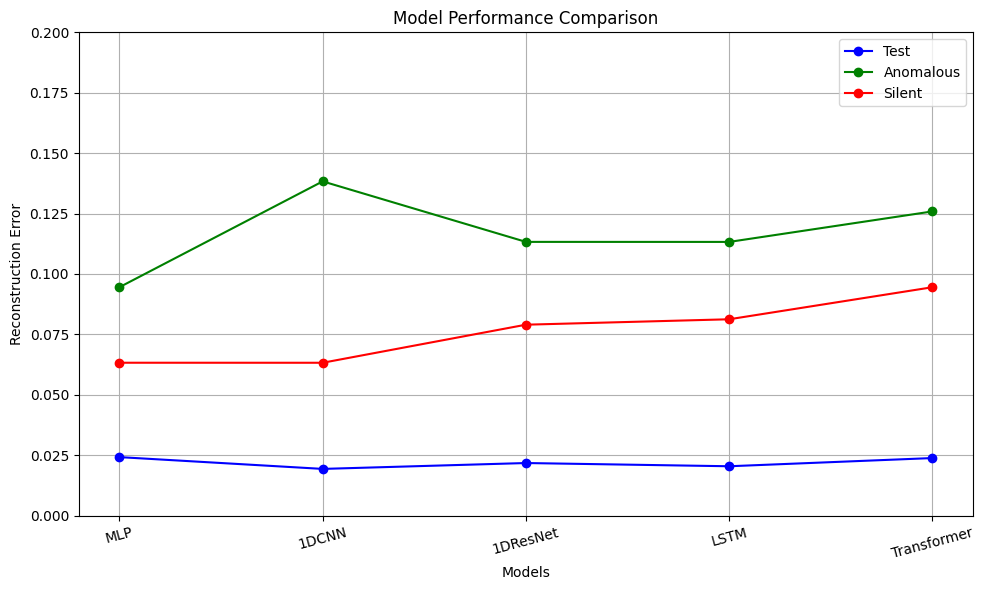

In [117]:
# plot models as x axis, test_perf, an_perf, silent_perf as 3 lines
# make a legend for the 3 lines 'Test', 'Anomalous', 'Silent'

# Create the plot
plt.figure(figsize=(10, 6))  # Set figure size
plt.plot(models, test_perf, marker='o', label='Test', color='b')  # Test performance
plt.plot(models, an_perf, marker='o', label='Anomalous', color='g')  # Anomalous performance
plt.plot(models, silent_perf, marker='o', label='Silent', color='r')  # Silent performance

# Add labels and title
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Reconstruction Error')
plt.ylim(0, 0.2)  # Set y-axis limits (0 to 1 for performance metrics)
plt.xticks(rotation=15)  # Rotate x-axis labels for better visibility
plt.grid()  # Add a grid for better readability
plt.legend()  # Add legend

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
plt.show()  # Display the plot